# Predicting Airbnb Occupancy in London: A Machine Learning Approach

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/konrad-kawka/airbnb_london/blob/main/airbnb_london.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/konrad-kawka/airbnb_london/blob/main/airbnb_london.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## 1.0 Setup

Importing neccessary libraries

In [3]:
import pandas as pd
import numpy as np

from pathlib import Path
import urllib.request
import shutil
import zipfile

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from pyproj import Transformer
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import contextily as ctx
import geopandas as gpd

from collections import Counter
import ast

from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.metrics.pairwise import rbf_kernel

Loading Airbnb London listings data into DataFrame

In [4]:
def load_airbnb_data():
    file_path = Path("datasets/listings.csv.gz")
    if not file_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz"
        urllib.request.urlretrieve(url, file_path)
    return pd.read_csv(file_path, low_memory=False)

In [5]:
airbnb = load_airbnb_data()

## 2.0 Initial Exploration

Displaying DataFrame's summary including data types and non-null counts.

In [6]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87946 entries, 0 to 87945
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            87946 non-null  int64  
 1   listing_url                                   87946 non-null  object 
 2   scrape_id                                     87946 non-null  int64  
 3   last_scraped                                  87946 non-null  object 
 4   source                                        87946 non-null  object 
 5   name                                          87946 non-null  object 
 6   description                                   86679 non-null  object 
 7   neighborhood_overview                         47190 non-null  object 
 8   picture_url                                   87943 non-null  object 
 9   host_id                                       87946 non-null 

Changing pandas display settings to make examination of example values in each column easier

In [7]:
pd.set_option('display.max_columns', None)

Looking at the first three rows of the dataset

In [9]:
airbnb.head(3)

id                         listing_url       scrape_id last_scraped  \
0  92644  https://www.airbnb.com/rooms/92644  20230906022807   2023-09-06   
1  93015  https://www.airbnb.com/rooms/93015  20230906022807   2023-09-06   
2  13913  https://www.airbnb.com/rooms/13913  20230906022807   2023-09-06   

        source                                               name  \
0  city scrape  Rental unit in Earlsfield · ★4.57 · 1 bedroom ...   
1  city scrape  Rental unit in Hammersmith · ★4.82 · 2 bedroom...   
2  city scrape  Rental unit in Islington · ★4.80 · 1 bedroom ·...   

                                         description  \
0  <b>The space</b><br />Hi everyone! I have 2 ro...   
1  Gorgeous 2 bed ground floor apartment with per...   
2  My bright double bedroom with a large window h...   

                               neighborhood_overview  \
0                                                NaN   
1  A bit of history about the W14 area: <br />Com...   
2  Finsbury Park is a friendly melting pot commun...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/715127/85bdb4...   498201   
1  https://a0.muscache.com/pictures/865937ec-ee56...   499704   
2  https://a0.muscache.com/pictures/miso/Hosting-...    54730   

                                   host_url host_name  host_since  \
0  https://www.airbnb.com/users/show/498201   Dee Dee  2011-04-10   
1  https://www.airbnb.com/users/show/499704     Sarah  2011-04-11   
2   https://www.airbnb.com/users/show/54730     Alina  2009-11-16   

            host_location                                         host_about  \
0  London, United Kingdom  I am employed at St Georges hospital in tootin...   
1  London, United Kingdom  Been living in London for over 20 years and I ...   
2  London, United Kingdom  I am a Multi-Media Visual Artist and Creative ...   

   host_response_time host_response_rate host_acceptance_rate  \
0                 NaN                NaN                 100%   
1  within a few hours               100%                  25%   
2  within a few hours               100%                  88%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/pictures/user/0edcb...   
1                 f  https://a0.muscache.com/im/pictures/user/452ff...   
2                 f  https://a0.muscache.com/im/users/54730/profile...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/0edcb...         Earlsfield   
1  https://a0.muscache.com/im/pictures/user/452ff...        Hammersmith   
2  https://a0.muscache.com/im/users/54730/profile...    LB of Islington   

   host_listings_count  host_total_listings_count  host_verifications  \
0                  1.0                        1.0  ['email', 'phone']   
1                  1.0                        2.0  ['email', 'phone']   
2                  3.0                        4.0  ['email', 'phone']   

  host_has_profile_pic host_identity_verified  \
0                    t                      t   
1                    t                      t   
2                    t                      t   

                               neighbourhood  neighbourhood_cleansed  \
0                                        NaN              Wandsworth   
1       Hammersmith, England, United Kingdom  Hammersmith and Fulham   
2  Islington, Greater London, United Kingdom               Islington   

   neighbourhood_group_cleansed  latitude  longitude  \
0                           NaN  51.44201   -0.18739   
1                           NaN  51.49993   -0.21707   
2                           NaN  51.56861   -0.11270   

                 property_type        room_type  accommodates  bathrooms  \
0  Private room in rental unit     Private room             2        NaN   
1           Entire rental unit  Entire home/apt             5        NaN   
2  Private room in r

Identifying columnns with no data

In [10]:
all_nan_columns = airbnb.columns[airbnb.isna().mean() == 1]
print(list(all_nan_columns))

['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated']


Identifying the most common amenities

In [11]:
amenity_counts = Counter()

for amenity_str in airbnb["amenities"]:
    amenity_list = ast.literal_eval(amenity_str)
    amenity_counts.update(amenity_list)

In [12]:
for amenity, count in amenity_counts.most_common(10):
    print(f"amenity: {amenity}, count: {count}")

amenity: Kitchen, count: 80119
amenity: Wifi, count: 79856
amenity: Smoke alarm, count: 78620
amenity: Essentials, count: 73523
amenity: Iron, count: 62614
amenity: Washer, count: 62061
amenity: Hangers, count: 62012
amenity: Hair dryer, count: 58645
amenity: Carbon monoxide alarm, count: 57722
amenity: Heating, count: 56960


## 3.0 Narrowing down the scope of analysis

Airbnb does not specify whether a listing is unavailable because it's booked or because the host has blocked it. If a listing is blocked for a significant period, its "reviews_per_month" may be inaccurately low. Therefore, an alternative metric was derived by dividing the total number of reviews by the number of days between the first and the last review.

In [13]:
first_review = pd.to_datetime(airbnb["first_review"])

In [14]:
last_review = pd.to_datetime(airbnb["last_review"])

Choosing listings with at least a year between the first and last reviews ensures that the 'occupancy_proxy' accurately represents long-term popularity

In [15]:
mask = ((last_review - first_review) >= pd.Timedelta(days=365))

In [16]:
airbnb_filtered = airbnb[mask].copy()

In [17]:
airbnb_filtered.shape

(27499, 75)

It can be seen, that the above steps reduced the number of listings from 87,946 to 27,499. However, incorporating listings that were added shortly before the data scraping, or those with a sparse number of reviews penned closely together in time, could introduce bias.

Only listings with "minimum_nights" less than 14 were included in the analysis, as some hosts use the website for long-term rentals, which are not the focus of this study.

In [18]:
airbnb_filtered = airbnb_filtered[airbnb_filtered["minimum_nights"] <= 14]

Since there is no distinction between actual bookings and the listing being blocked by the host, "availability_365" could not be used as a meassure of occupancy. It was assumed that the number of reviews is a good enough proxy for the popularity of a listing.

In [19]:
airbnb_filtered["occupancy_proxy"] = airbnb_filtered["number_of_reviews"] / (last_review - first_review).dt.days * 365

In [20]:
airbnb_filtered["occupancy_proxy"][:5]

0    19.006750
1     3.561890
2     3.327034
3     7.032179
4    14.774005
Name: occupancy_proxy, dtype: float64

In [21]:
airbnb_filtered.loc[:5, ["host_since", "number_of_reviews", "number_of_reviews_ltm", "first_review", "last_review", "availability_365"]]

host_since  number_of_reviews  number_of_reviews_ltm first_review  \
0  2011-04-10                216                      9   2011-06-21   
1  2011-04-11                 38                      2   2012-02-01   
2  2009-11-16                 41                     11   2010-08-18   
3  2009-12-05                 94                      5   2009-12-21   
4  2011-04-10                180                     25   2011-06-30   
5  2010-01-04                 54                      4   2011-03-21   

  last_review  availability_365  
0  2022-10-29               217  
1  2022-09-30                40  
2  2022-12-11               360  
3  2023-05-01                73  
4  2023-09-02               196  
5  2022-11-19               300

## 4.0 Exploratory Data Analysis

Creating a test set

In [22]:
air_train, air_test = train_test_split(airbnb_filtered, test_size = 0.2, random_state=42)

In [23]:
air_train.shape

(21033, 76)

In [24]:
air_test.shape

(5259, 76)

Selecting a subset of variables. The focus shifts towards variables that are deemed most likely to be related to the popularity of a listing.

In [25]:
cols = ["host_since",
        "amenities",
        "host_response_time",
        "host_response_rate",
        "host_acceptance_rate",
        "host_listings_count",
        "host_has_profile_pic",
        "host_identity_verified",
        "neighbourhood_cleansed",
        "latitude",
        "longitude",
        "room_type",
        "accommodates",
        "beds",
        "price",
        "minimum_nights",
        "maximum_nights",
        "occupancy_proxy"]

In [26]:
air_train_subset = air_train[cols]

In [27]:
air_train_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21033 entries, 36870 to 49554
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_since              21033 non-null  object 
 1   amenities               21033 non-null  object 
 2   host_response_time      16027 non-null  object 
 3   host_response_rate      16027 non-null  object 
 4   host_acceptance_rate    17303 non-null  object 
 5   host_listings_count     21033 non-null  float64
 6   host_has_profile_pic    21033 non-null  object 
 7   host_identity_verified  21033 non-null  object 
 8   neighbourhood_cleansed  21033 non-null  object 
 9   latitude                21033 non-null  float64
 10  longitude               21033 non-null  float64
 11  room_type               21033 non-null  object 
 12  accommodates            21033 non-null  int64  
 13  beds                    20735 non-null  float64
 14  price                   21033 non-

Before diving into creating histograms to visualize the distributions, we'll convert numerical variables that are formatted as strings into float type.

In [28]:
host_response_rate = air_train_subset["host_response_rate"].apply(lambda x: float(x[:-1]) if type(x) == str else x)

In [29]:
host_acceptance_rate = air_train_subset["host_acceptance_rate"].apply(lambda x: float(x[:-1]) if type(x) == str else x)

In [30]:
price = air_train["price"].apply(lambda x: float(x[1:].replace(",", "")))

The following line calculates the number of days between the current date, and the date the host registered on the website

In [31]:
days_hosting = (pd.Timestamp.now() - pd.to_datetime(air_train_subset["host_since"])).dt.days

Creting a data frame contaning the numerical variables

In [32]:
air_train_num = pd.DataFrame({"host_response_rate": host_response_rate,
                              "host_acceptance_rate": host_acceptance_rate,
                              "days_hosting": days_hosting,
                              "price": price,
                              "host_listings_count": air_train_subset["host_listings_count"],
                              "accomomdates": air_train_subset["accommodates"],
                              "minimum_nights": air_train_subset["minimum_nights"],
                              "maximum_nights": air_train_subset["maximum_nights"],
                              "beds": air_train_subset["beds"]})

Exploring the distributions using histograms

In [33]:
figures_path = Path() / "figures"
figures_path.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="svg"):
    path = figures_path / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension)

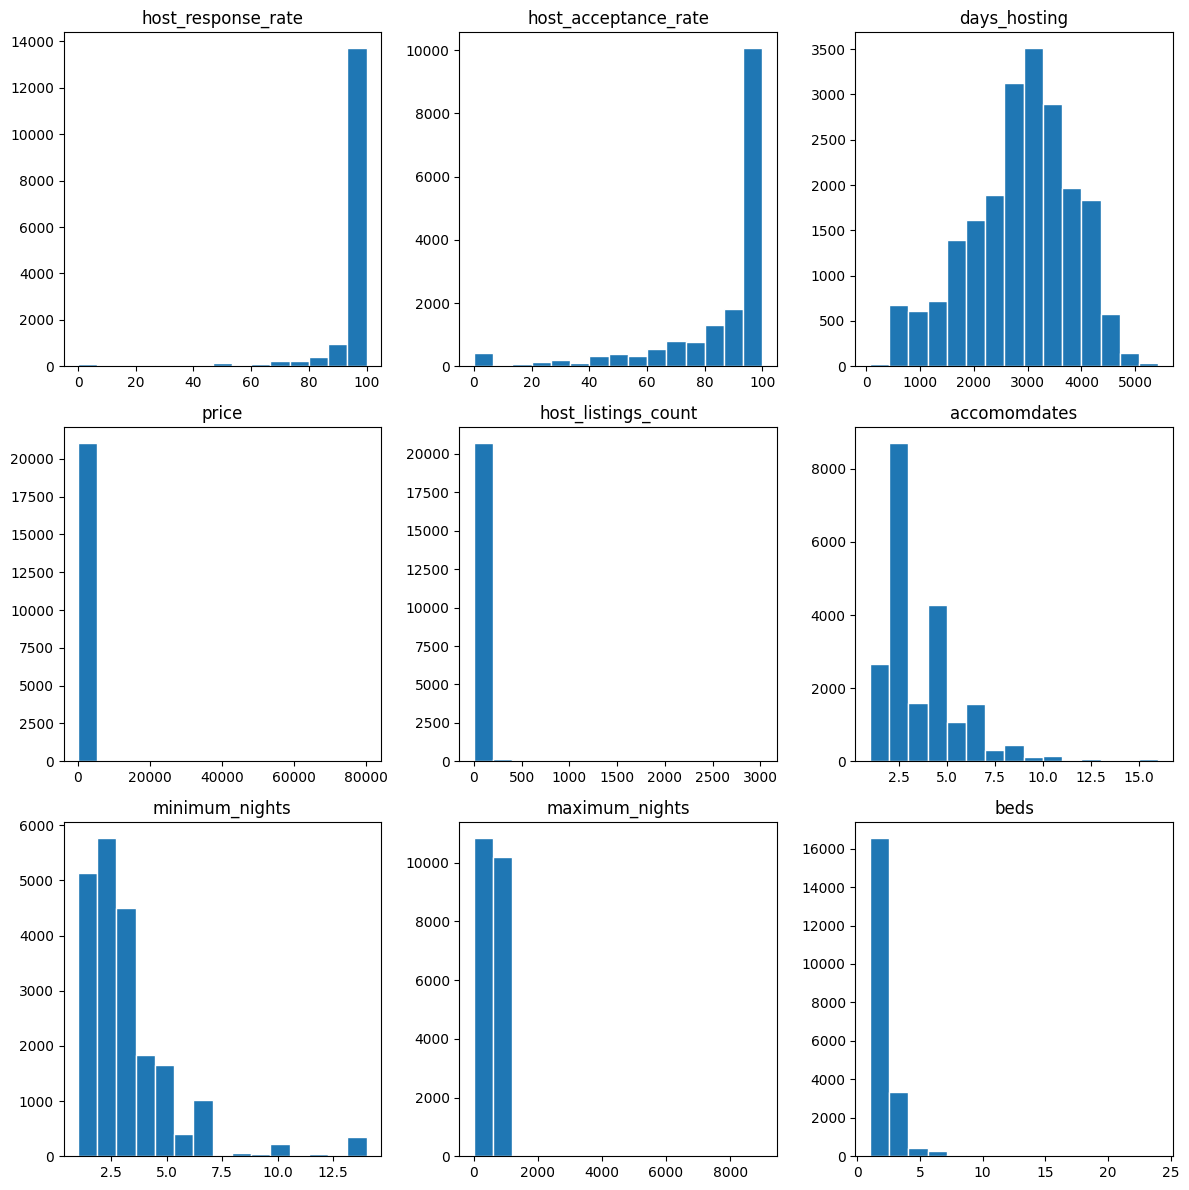

In [34]:
air_train_num.hist(figsize=(12, 12), grid=False, edgecolor="white", bins=15)
save_fig("histograms")

Exploring the distribution of the target variable

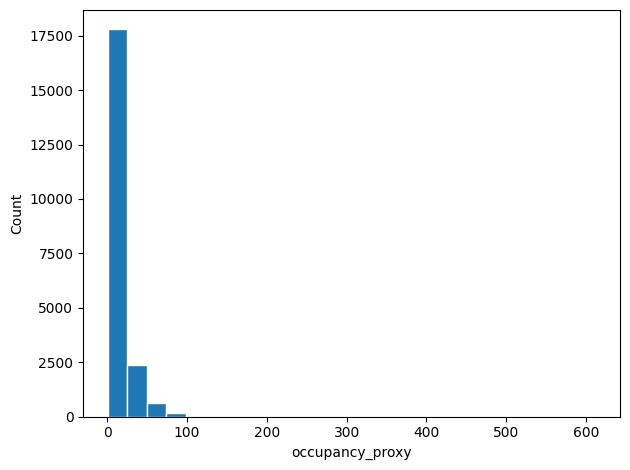

In [35]:
air_train_subset["occupancy_proxy"].hist(grid=False, edgecolor="white", bins=25)
plt.xlabel("occupancy_proxy")
plt.ylabel("Count")
save_fig("target_var_histogram")

The distributions of categorical variables are explored using bar charts

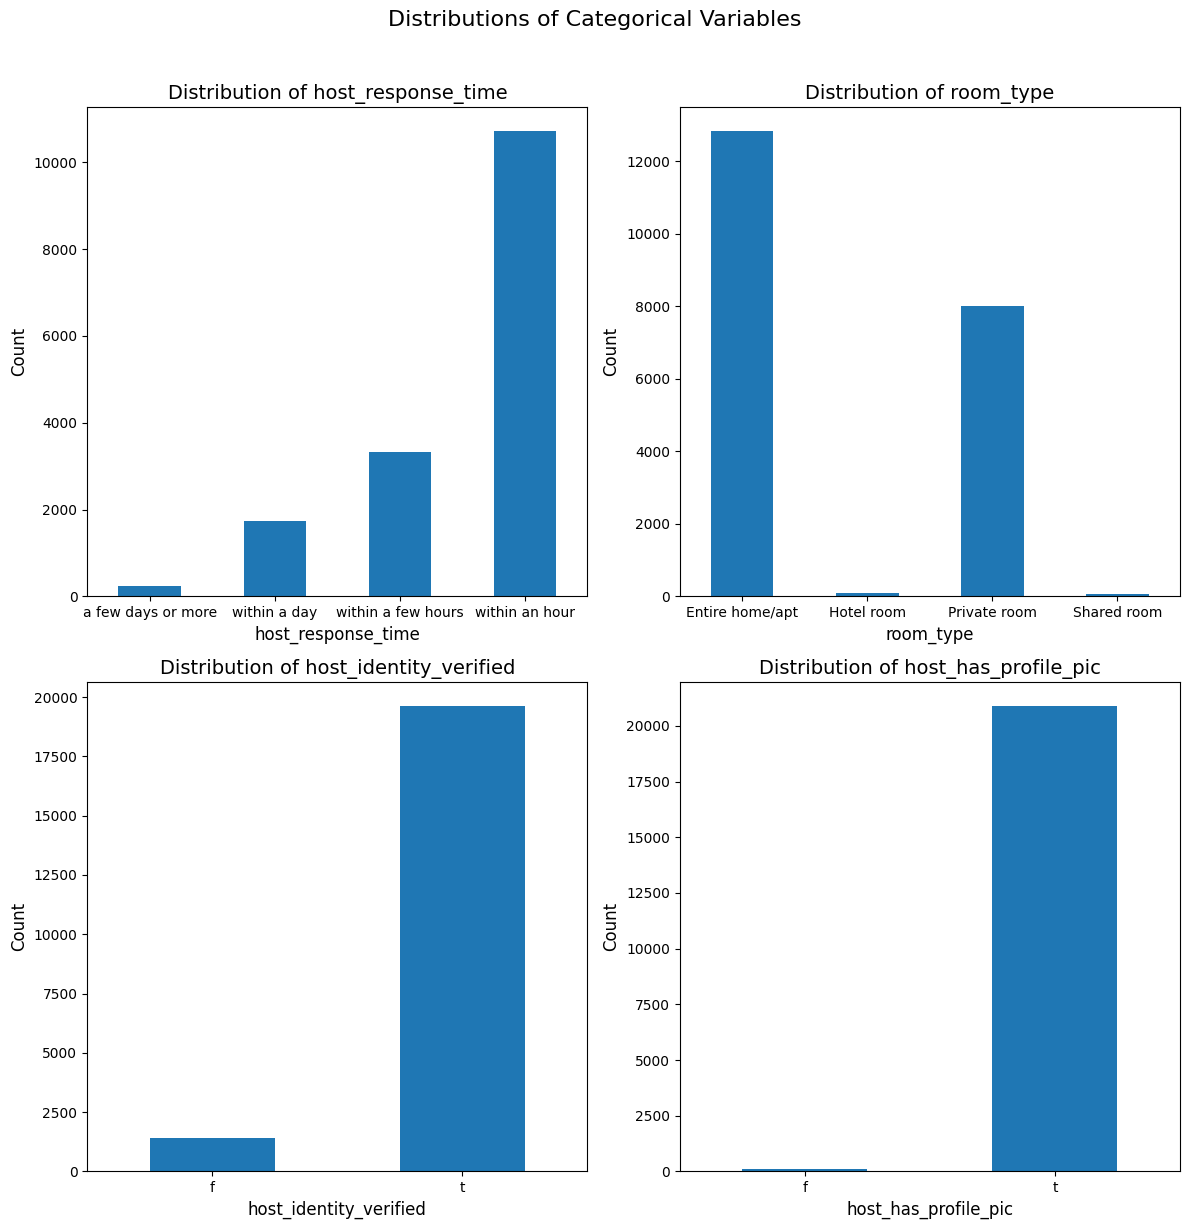

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 2x2 grid of plots
axs = axs.flatten()  # Flatten the 2D array to 1D for easier indexing
variables = ["host_response_time", "room_type", "host_identity_verified", "host_has_profile_pic"]  # Replace these with your column names

# Iterate through axs and variables to create bar plots
for ax, variable in zip(axs, variables):
    air_train_subset[variable].value_counts().sort_index().plot(kind='bar', ax=ax, grid=False, rot=0)
    ax.set_title(f'Distribution of {variable}', fontsize=14)
    ax.set_xlabel(variable, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Distributions of Categorical Variables', fontsize=16, y=1.02)
save_fig("bar_charts")
plt.show()

Calculating the number of listing for each borough of London

In [37]:
listings_per_borough = air_train_subset["neighbourhood_cleansed"].value_counts()
listings_per_borough = listings_per_borough.reset_index()
listings_per_borough.columns = ["borough", "listings_count"]
listings_per_borough

borough  listings_count
0              Westminster            2424
1                  Hackney            1605
2                   Camden            1593
3            Tower Hamlets            1493
4   Kensington and Chelsea            1456
5                Southwark            1259
6                  Lambeth            1232
7                Islington            1122
8               Wandsworth            1026
9   Hammersmith and Fulham             953
10                Lewisham             636
11                   Brent             630
12                Haringey             562
13                  Ealing             483
14                  Newham             470
15               Greenwich             426
16                  Barnet             410
17          Waltham Forest             387
18    Richmond upon Thames             380
19                  Merton             355
20                 Croydon             302
21                Hounslow             299
22              Hillingdon             216
23                 Enfield             188
24    Kingston upon Thames             180
25               Redbridge             172
26                 Bromley             164
27          City of London             136
28                  Harrow             126
29                Havering              97
30                  Bexley              87
31    Barking and Dagenham              83
32                  Sutton              81

Creating a choropleth map to visualize the above data

In [38]:
def load_shapefiles():
    # Paths
    target_directory = Path("shapefiles")
    zip_file_path = target_directory / "london_boroughs.zip"
    temp_directory = Path("temp_shapefiles")

    # Check if shapefiles are already present
    shp_path = target_directory / "london_boroughs.shp"
    if not shp_path.exists():
        # Ensure directories exist
        target_directory.mkdir(parents=True, exist_ok=True)
        temp_directory.mkdir(parents=True, exist_ok=True)

        # Download the zip file
        url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"
        urllib.request.urlretrieve(url, zip_file_path)

        # Extract the zip file to a temporary directory
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(temp_directory)

        # Move the relevant shapefiles to the target directory and rename
        extensions = [".shp", ".shx", ".dbf", ".prj"]
        for ext in extensions:
            source_file = temp_directory / "statistical-gis-boundaries-london" / "ESRI" / f"London_Borough_Excluding_MHW{ext}"
            target_file = target_directory / f"london_boroughs{ext}"
            shutil.move(source_file, target_file)

        # Cleanup: remove temporary directory and the downloaded zip file
        shutil.rmtree(temp_directory)
        zip_file_path.unlink()

    return gpd.read_file("shapefiles/london_boroughs.shp")

In [39]:
choropleth_gdf = load_shapefiles()

In [40]:
choropleth_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        33 non-null     object  
 1   GSS_CODE    33 non-null     object  
 2   HECTARES    33 non-null     float64 
 3   NONLD_AREA  33 non-null     float64 
 4   ONS_INNER   33 non-null     object  
 5   SUB_2009    0 non-null      object  
 6   SUB_2006    0 non-null      object  
 7   geometry    33 non-null     geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 2.2+ KB


In [41]:
choropleth_gdf.head()

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F     None   
1               Croydon  E09000008   8649.441       0.000         F     None   
2               Bromley  E09000006  15013.487       0.000         F     None   
3              Hounslow  E09000018   5658.541      60.755         F     None   
4                Ealing  E09000009   5554.428       0.000         F     None   

  SUB_2006                                           geometry  
0     None  POLYGON ((516401.600 160201.800, 516407.300 16...  
1     None  POLYGON ((535009.200 159504.700, 535005.500 15...  
2     None  POLYGON ((540373.600 157530.400, 540361.200 15...  
3     None  POLYGON ((521975.800 178100.000, 521967.700 17...  
4     None  POLYGON ((510253.500 182881.600, 510249.900 18...

Making sure there is a perfct overlap between the boroughs in the original dataframe and in the shape file

In [42]:
np.intersect1d(choropleth_gdf.NAME, listings_per_borough.borough).shape

(33,)

In [43]:
polygons_with_listing_counts = choropleth_gdf.merge(listings_per_borough, left_on="NAME", right_on="borough", how="left")

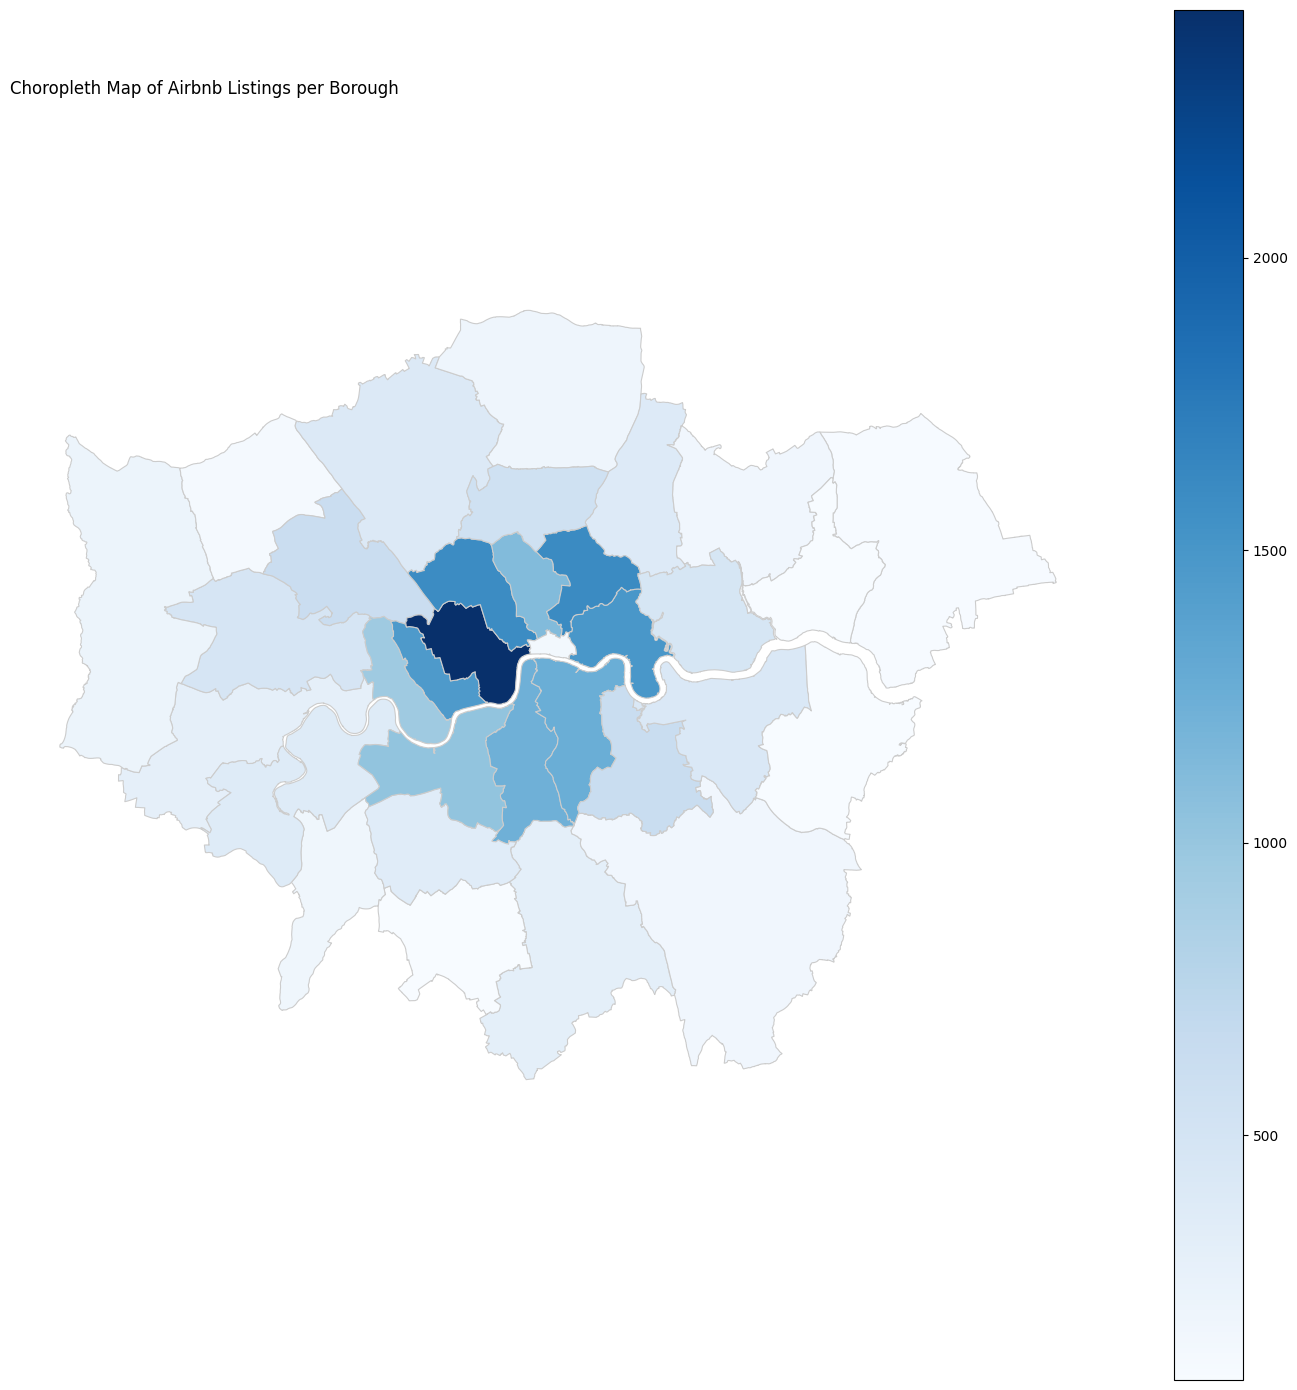

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

polygons_with_listing_counts.plot(column="listings_count", cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)
ax.axis("off")
ax.set_title('Choropleth Map of Airbnb Listings per Borough',
             fontdict={'fontsize': '12', 'fontweight' : '3'},
             loc='left',
             y=1.20)
save_fig("choropleth_map_listings_per_borough")

## 5.0 Handling Outliers

The histograms for each numeric variable are created once again, to examine if there are any extreme values

array([[<Axes: title={'center': 'host_response_rate'}>,
        <Axes: title={'center': 'host_acceptance_rate'}>,
        <Axes: title={'center': 'days_hosting'}>],
       [<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'host_listings_count'}>,
        <Axes: title={'center': 'accomomdates'}>],
       [<Axes: title={'center': 'minimum_nights'}>,
        <Axes: title={'center': 'maximum_nights'}>,
        <Axes: title={'center': 'beds'}>]], dtype=object)

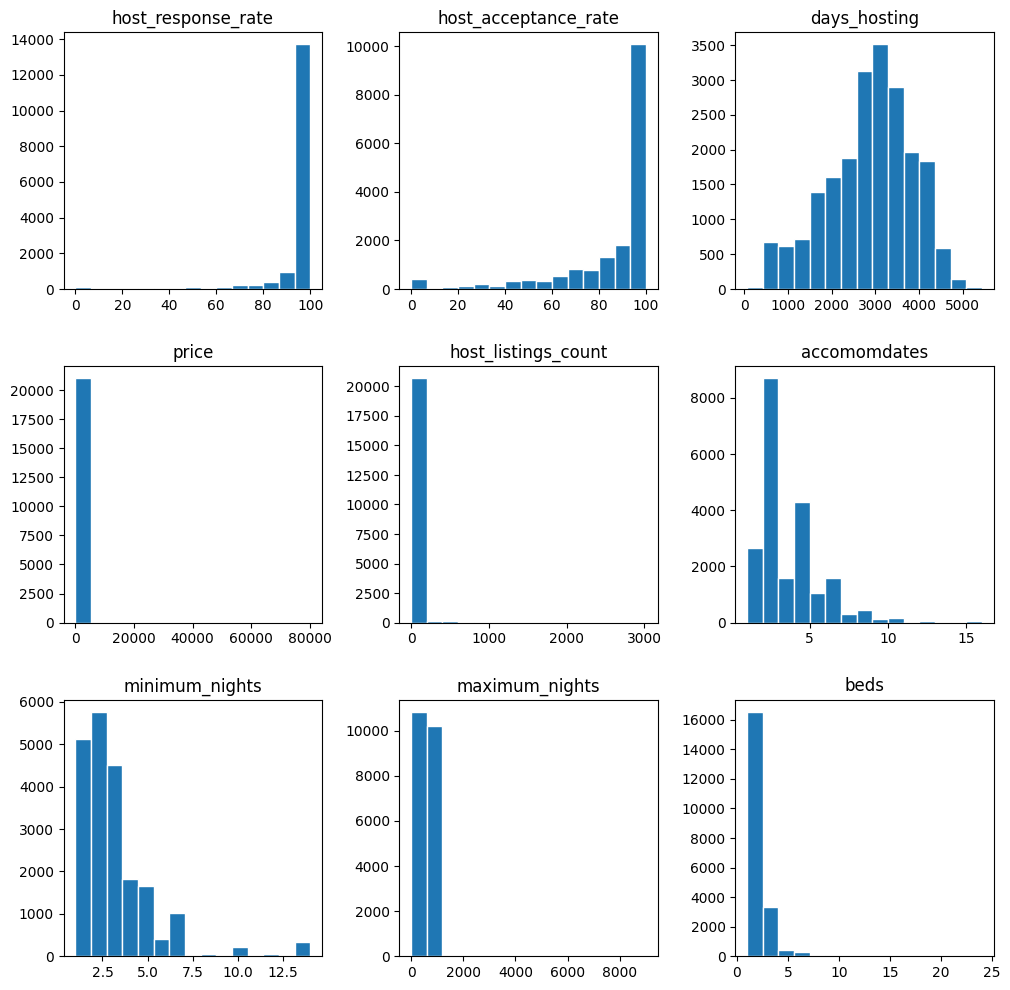

In [45]:
air_train_num.hist(figsize=(12, 12), grid=False, edgecolor="white", bins=15)


The first two variables: "host_response_rate" and "host_acceptance_rate" are defined respectively as the number of times the host replied to an enquiry within 24h devided by the total number of enquiries, and the number of approved booking request devided by the total number of booking request ([Airbnb](https://community.withairbnb.com/t5/Airbnb-updates/Understanding-Response-Rate-and-Acceptance-Rate/td-p/761075#:~:text=Your%20response%20rate%20measures%20how,you%20accept%20or%20decline%20reservations.), 2018).

In [46]:
(air_train_num["host_response_rate"] == 0).sum()

117

In [47]:
(air_train_num["host_acceptance_rate"] == 0).sum()

404

Since both variables are ratios, they will not exhibit outliers in the traditional sense. However, one can note that the values of 0 are far from the bulk of the distribution, especially for "host_response_rate". It was found that the value of 0 is highly correlated with the response time "a few days of more" which makes sense given the definition.

In [48]:
air_train[air_train_num["host_response_rate"] == 0][["host_response_rate", "host_response_time"]][:15]

host_response_rate  host_response_time
19188                 0%  a few days or more
47103                 0%  a few days or more
25518                 0%  a few days or more
32811                 0%  a few days or more
37493                 0%  a few days or more
21194                 0%  a few days or more
1285                  0%  a few days or more
14231                 0%  a few days or more
12071                 0%  a few days or more
19972                 0%  a few days or more
15997                 0%  a few days or more
47269                 0%  a few days or more
24786                 0%  a few days or more
47283                 0%  a few days or more
10216                 0%  a few days or more

Since the response rate is updated relatively often and some listings websites don't provide it at all, it would be difficult to examine if values of 0 are data entry mistakes. Some of the above listings do indeed belong to hosts with a 0% response rate, hence it was decided to assume data points with 0% response rate were valid. Unfortunately, acceptance rate is not provided on the website and it is not clear how the Inside Airbnb team obtained it.

In [49]:
air_train_num.sort_values(by="price", ascending=False).reset_index().loc[:15, ["price"]]

price
0   80100.0
1   53588.0
2   25000.0
3   25000.0
4    9999.0
5    6089.0
6    5100.0
7    5000.0
8    4656.0
9    4304.0
10   4000.0
11   4000.0
12   3797.0
13   3738.0
14   3489.0
15   3300.0

Number of days hosting was skipped, since it exhibits a roughly symetric distribution with no extreme values. However, the distribution of a daily price is highly skewed, with a long tail to the right. It was decided to examine the listings with the most extreme prices.

In [50]:
indices = price.sort_values(ascending=False).index

In [51]:
air_train.loc[indices, ["listing_url", "minimum_nights", "price"]][:15]

listing_url  minimum_nights  \
36165            https://www.airbnb.com/rooms/38452677               2   
11248            https://www.airbnb.com/rooms/13254774               3   
54916  https://www.airbnb.com/rooms/662813797003338934               3   
39139            https://www.airbnb.com/rooms/41923555               1   
41421            https://www.airbnb.com/rooms/44696103               1   
9198             https://www.airbnb.com/rooms/10914219               4   
16647            https://www.airbnb.com/rooms/18344241               3   
34915            https://www.airbnb.com/rooms/37120183               1   
25334            https://www.airbnb.com/rooms/25498368               3   
2555              https://www.airbnb.com/rooms/3430656              14   
30049            https://www.airbnb.com/rooms/31168521               4   
7847              https://www.airbnb.com/rooms/9470175               1   
24368            https://www.airbnb.com/rooms/24507675               7   
16017            https://www.airbnb.com/rooms/17768576               2   
17629            https://www.airbnb.com/rooms/19132451               3   

            price  
36165  $80,100.00  
11248  $53,588.00  
54916  $25,000.00  
39139  $25,000.00  
41421   $9,999.00  
9198    $6,089.00  
16647   $5,100.00  
34915   $5,000.00  
25334   $4,656.00  
2555    $4,304.00  
30049   $4,000.00  
7847    $4,000.00  
24368   $3,797.00  
16017   $3,738.00  
17629   $3,489.00

Examination of the most expensive listing using the URLs revealed that the 5 most expensive listing were likely incorrect amonts entered by the hosts. The most expensive listing that looked genuine was the one priced 6,557 dollars per night.

In [52]:
air_train.loc[indices[::-1], ["listing_url", "minimum_nights", "price"]][:15]

listing_url  minimum_nights   price
51111  https://www.airbnb.com/rooms/600362450278687038               5   $8.00
10261            https://www.airbnb.com/rooms/12142193               3   $8.00
45152            https://www.airbnb.com/rooms/50592352               1  $11.00
45013            https://www.airbnb.com/rooms/50511015               1  $11.00
21368            https://www.airbnb.com/rooms/21712876               1  $12.00
294                https://www.airbnb.com/rooms/388700               1  $12.00
19007            https://www.airbnb.com/rooms/20051612               4  $12.00
42342            https://www.airbnb.com/rooms/46067306               1  $12.00
17069            https://www.airbnb.com/rooms/18688216              14  $13.00
30348            https://www.airbnb.com/rooms/31490015              10  $14.00
49689  https://www.airbnb.com/rooms/552522440427495140               1  $15.00
6460              https://www.airbnb.com/rooms/7930974               1  $15.00
22200            https://www.airbnb.com/rooms/22323097               1  $15.00
10170            https://www.airbnb.com/rooms/12102930               3  $15.00
40923            https://www.airbnb.com/rooms/44134466               7  $15.00

When it comes to the lower limit for the price, all $0.00 listings have broken links. The cheapest listings that is actually available, and that looks genuine was the listing No.21576 priced at 12 dollars a night.

In [53]:
indices = air_train_subset["host_listings_count"].sort_values(ascending=False).index

In [54]:
air_train.loc[indices, ["listing_url", "host_total_listings_count"]][:15]

listing_url  host_total_listings_count
42955  https://www.airbnb.com/rooms/47114739                     5076.0
41807  https://www.airbnb.com/rooms/45450285                     5076.0
43664  https://www.airbnb.com/rooms/48991371                     5076.0
43674  https://www.airbnb.com/rooms/48991572                     5076.0
43683  https://www.airbnb.com/rooms/48991946                     3332.0
43251  https://www.airbnb.com/rooms/48050923                     3332.0
45738  https://www.airbnb.com/rooms/51180286                     3332.0
43261  https://www.airbnb.com/rooms/48050992                     3332.0
44146  https://www.airbnb.com/rooms/49623499                     3332.0
47228  https://www.airbnb.com/rooms/52727031                     5272.0
44513  https://www.airbnb.com/rooms/49893047                     5272.0
44503  https://www.airbnb.com/rooms/49993058                     5272.0
38393  https://www.airbnb.com/rooms/40775960                     5272.0
44504  https://www.airbnb.com/rooms/49993073                     5272.0
28808  https://www.airbnb.com/rooms/29702647                      676.0

The next variable that prompted examination was "host_total_listings_count" which also exhibited a right-shewed distribution, with the histogram indicating presence of some unusually high values. Since this variable is related to a host, rather to an individual listing, it was decided to group the data by host using mean.

In [55]:
air_train.groupby(["host_id"]).mean(numeric_only=True).sort_values(by="host_total_listings_count", ascending=False).reset_index().loc[:10, ["host_total_listings_count"]]

host_total_listings_count
0                      5272.0
1                      5076.0
2                      3332.0
3                      1691.0
4                      1084.0
5                       813.0
6                       676.0
7                       595.0
8                       590.0
9                       530.0
10                      504.0

Upon examination, hosts with the highest number of listings turned out to be actual proptech companies and vacation rental advertising platforms.

In [56]:
indices = air_train_subset["maximum_nights"].sort_values(ascending=False).index

In [57]:
air_train.loc[indices, ["listing_url", "maximum_nights", "minimum_maximum_nights"]][:15]

listing_url  maximum_nights  \
191      https://www.airbnb.com/rooms/270600            9011   
6712    https://www.airbnb.com/rooms/8168705            2000   
283      https://www.airbnb.com/rooms/343754            1825   
2231    https://www.airbnb.com/rooms/2836575            1444   
36607  https://www.airbnb.com/rooms/39070453            1125   
8349    https://www.airbnb.com/rooms/9832548            1125   
22569  https://www.airbnb.com/rooms/22625734            1125   
4523    https://www.airbnb.com/rooms/6268399            1125   
6301    https://www.airbnb.com/rooms/7769244            1125   
40406  https://www.airbnb.com/rooms/43144978            1125   
18072  https://www.airbnb.com/rooms/19464965            1125   
19350  https://www.airbnb.com/rooms/20230398            1125   
794      https://www.airbnb.com/rooms/604185            1125   
13665  https://www.airbnb.com/rooms/15389215            1125   
40760  https://www.airbnb.com/rooms/43897036            1125   

       minimum_maximum_nights  
191                    9011.0  
6712                   2000.0  
283                    1825.0  
2231                   1444.0  
36607                  1125.0  
8349                   1125.0  
22569                  1125.0  
4523                   1125.0  
6301                   1125.0  
40406                  1125.0  
18072                  1125.0  
19350                  1125.0  
794                    1125.0  
13665                  1125.0  
40760                  1125.0

The number of beds ("beds"), the maximum number of people the listing can accommodate ("accommodates") and the minimum nuber of nights the listing can be booked for ("minimum_nights") all had plausible ranges of values. The only remaining variable that was investigated was the maximum number of nights the listing can be booked for ("maximum_nights"), since it had some extremely large values. Upon examination of corresponding listings, it was decided that this variable contained a lot of arbitrary and incorrect values, hence the entire column was excluded from the analysis.

## 6.0 Data Cleaning

In the end, it was decided to remove all listings with daily prices higher than 7000 dollars and smaller than $12

In [58]:
air_train_cleaned = air_train_subset[(price <= 7000) & (price >= 12)].drop("maximum_nights", axis=1).copy()

In [59]:
air_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21024 entries, 36870 to 49554
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_since              21024 non-null  object 
 1   amenities               21024 non-null  object 
 2   host_response_time      16022 non-null  object 
 3   host_response_rate      16022 non-null  object 
 4   host_acceptance_rate    17297 non-null  object 
 5   host_listings_count     21024 non-null  float64
 6   host_has_profile_pic    21024 non-null  object 
 7   host_identity_verified  21024 non-null  object 
 8   neighbourhood_cleansed  21024 non-null  object 
 9   latitude                21024 non-null  float64
 10  longitude               21024 non-null  float64
 11  room_type               21024 non-null  object 
 12  accommodates            21024 non-null  int64  
 13  beds                    20729 non-null  float64
 14  price                   21024 non-

## 7.0 Effects of data cleaning

In [60]:
air_train_num_cleaned = air_train_num[(price <= 7000) & (price >= 12)].drop("maximum_nights", axis=1).copy()

<Axes: >

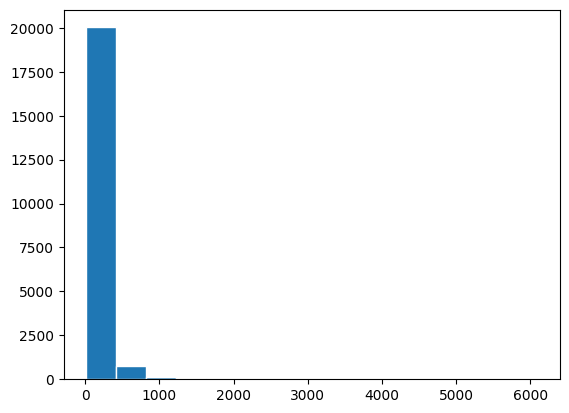

In [61]:
air_train_num_cleaned["price"].hist(bins=15, edgecolor="white", grid=False)

## 8.0 Examining Listing Variability within Individual Hosts

Clearly there are natural groups in the data, since there are cases when many listings belong to the same host. It was decided to examine the variability of "occupancy_proxy" for each individual host.

In [62]:
occupancy_std_per_host = air_train[air_train["host_listings_count"] > 5].groupby("host_id").std(numeric_only=True)["occupancy_proxy"]
occupancy_std_per_host.sort_values(ascending=True)[:15]

host_id
451620085    0.000000
6010300      0.053253
224967268    0.108295
66622217     0.173876
134721761    0.174937
22791764     0.187925
127522685    0.206951
212195110    0.229838
49798582     0.242721
4687837      0.248170
189764075    0.315838
10417843     0.323494
65883612     0.325759
251557639    0.361270
3757960      0.368124
Name: occupancy_proxy, dtype: float64

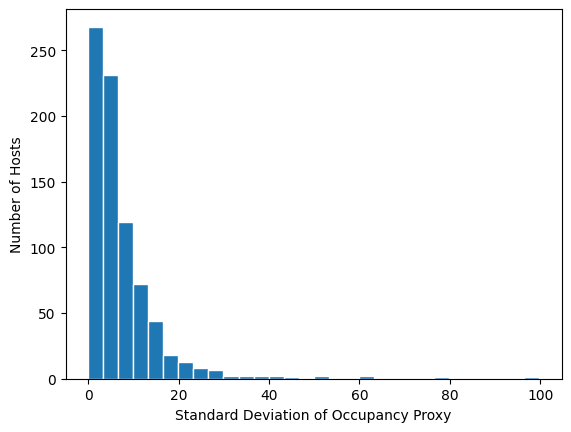

In [63]:
occupancy_std_per_host[occupancy_std_per_host < 100].hist(grid=False, edgecolor="white", bins=30)
plt.xlabel("Standard Deviation of Occupancy Proxy")
plt.ylabel("Number of Hosts")
plt.savefig("figures/within_host_variability.svg")

## 9.0 Feature Engineering

The dataset provided by Inside Airbnb contains approximate geographical coordinates of each listing. It was decided to to use this information, along with the derived "occupancy_proxy" to identify clusters with high density of airbnb's, with more weight given to popular listings.

In [64]:
transformed_data = np.log(air_train_cleaned["occupancy_proxy"])

In [65]:
gdf_clusters = gpd.GeoDataFrame(air_train_cleaned, geometry=gpd.points_from_xy(air_train_cleaned.longitude, air_train_cleaned.latitude))

In [66]:
gdf_clusters.crs = "EPSG:4326"

The following class has a *fit* method which emplys the KMeans algorithm to identify selected number of clusters using the first two columns of the provided dataframe, while the third column is used to assign a weight to each data point. It then calculates the similaritiy of each data point to each of the n clustrs in terms of the Radial Basis Function (RBF).

In [67]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None):
        # Convert DataFrame to numpy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.values

        # Assuming the last column of X is the sample_weight
        sample_weight = X[:, -1] ** 4  # Apply the power of 4 transformation
        data = X[:, :-1]

        self.kmeans_ = KMeans(self.n_clusters, n_init=25, random_state=self.random_state)
        self.kmeans_.fit(data, sample_weight=sample_weight)
        return self # always return self!

    def transform(self, X):
        check_is_fitted(self)

        # Convert DataFrame to numpy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.values

        data = X[:, :-1]  # Exclude the sample_weight column for transformation
        return rbf_kernel(data, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [68]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=75., random_state=42)
similarities = cluster_simil.fit_transform(air_train_cleaned[["longitude", "latitude", "occupancy_proxy"]])

Plotting each data point on a map of London. Each of the obtained clusters is represented by a red digit.

In [69]:
centroids = cluster_simil.kmeans_.cluster_centers_

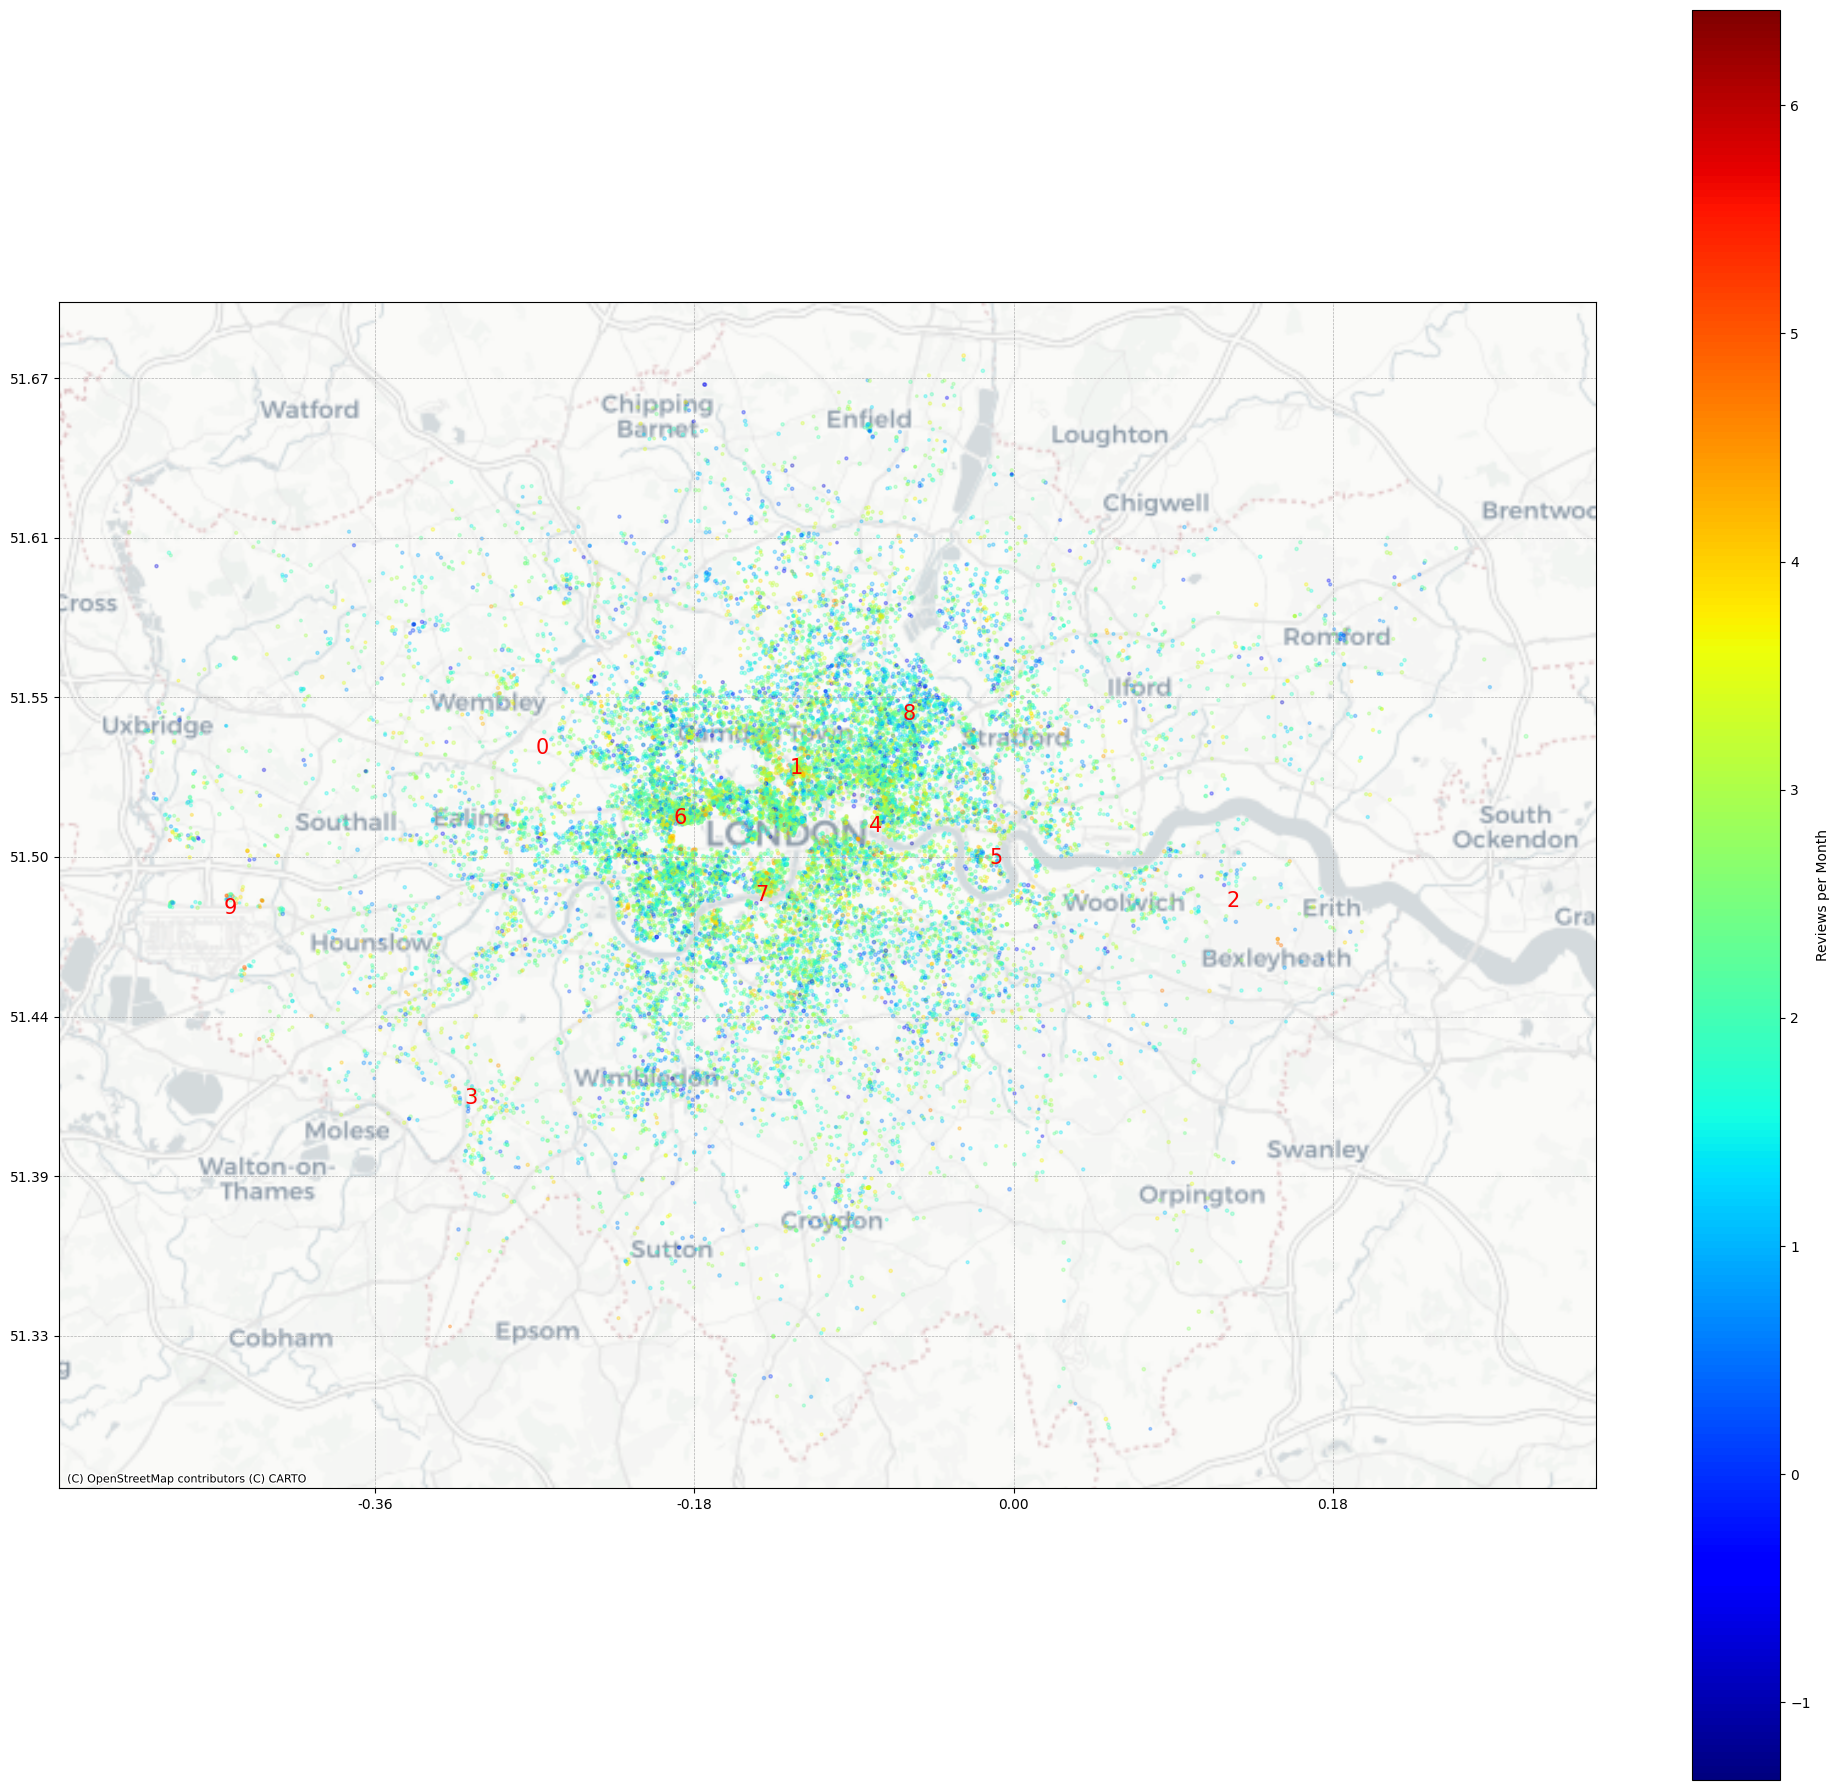

In [70]:
fig, ax = plt.subplots(figsize=(20, 18))

# Create a colormap
cmap = plt.get_cmap('jet')
norm = Normalize(vmin=transformed_data.min(),
                 vmax=transformed_data.max())

# Convert to Web Mercator
gdf_clusters = gdf_clusters.to_crs(epsg=3857)

# Plot the GeoDataFrame
gdf_clusters.plot(ax=ax,
             color=cmap(norm(transformed_data)),
             markersize=np.log(price),
             alpha=0.3)

centroids_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(centroids[:, 0], centroids[:, 1])
)

# Transform to Web Mercator
centroids_gdf = centroids_gdf.set_crs(epsg=4326).to_crs(epsg=3857)

# Loop through the centroids and annotate each one with its number
for idx, point in enumerate(centroids_gdf.geometry):
    ax.text(point.x, point.y, str(idx), color='red', fontsize=15, ha='center', va='center')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create a colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=ax, orientation='vertical', label='Reviews per Month')

# Add grid with rounded tick labels
xticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 5)
yticks = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5)

# Create a transformer to convert from Web Mercator to WGS 84
transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")

def x_formatter(x, pos):
    _, lon = transformer.transform(x, 0)  # Use x as longitude and 0 for latitude
    return f"{lon:.2f}"

def y_formatter(y, pos):
    lat, _ = transformer.transform(0, y)  # Use 0 for longitude and y as latitude
    return f"{lat:.2f}"

# Convert xticks and yticks from Web Mercator to WGS 84
xticks_latlon = [transformer.transform(x, 0)[0] for x in xticks]
yticks_latlon = [transformer.transform(0, y)[1] for y in yticks]


ax.xaxis.set_major_formatter(FuncFormatter(x_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(y_formatter))

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

save_fig("clusters")

plt.show()

## 10.0 Checking for multicollinearity

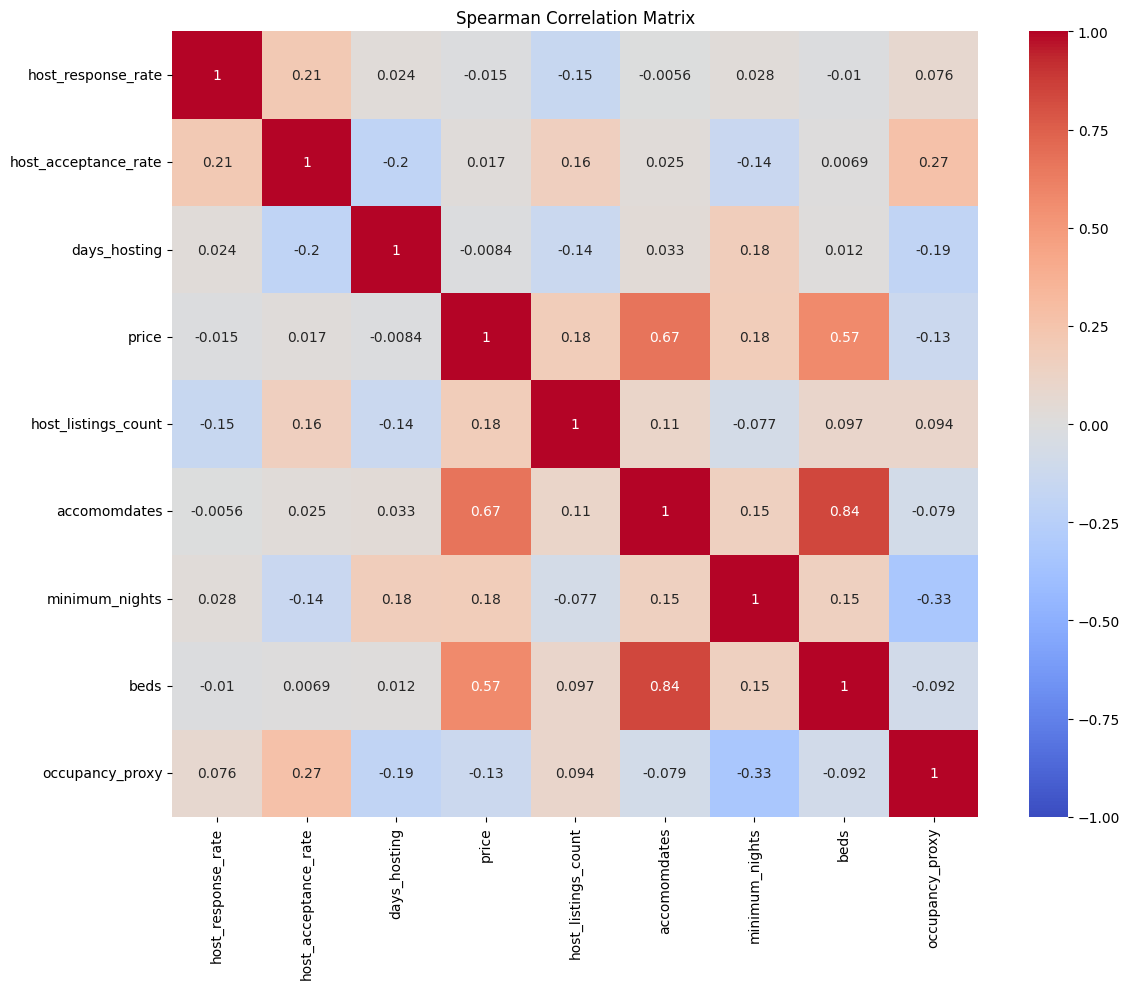

In [71]:
air_train_num_cleaned["occupancy_proxy"] = air_train_cleaned["occupancy_proxy"].copy()

correlations = air_train_num_cleaned.corr(method="spearman")

plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman Correlation Matrix")
save_fig("correlation_matrix")
plt.show()

## 11.0 EDA Part II

Plotting the scatterplots of each numerical predictor against the target variable ("occupancy_proxy")

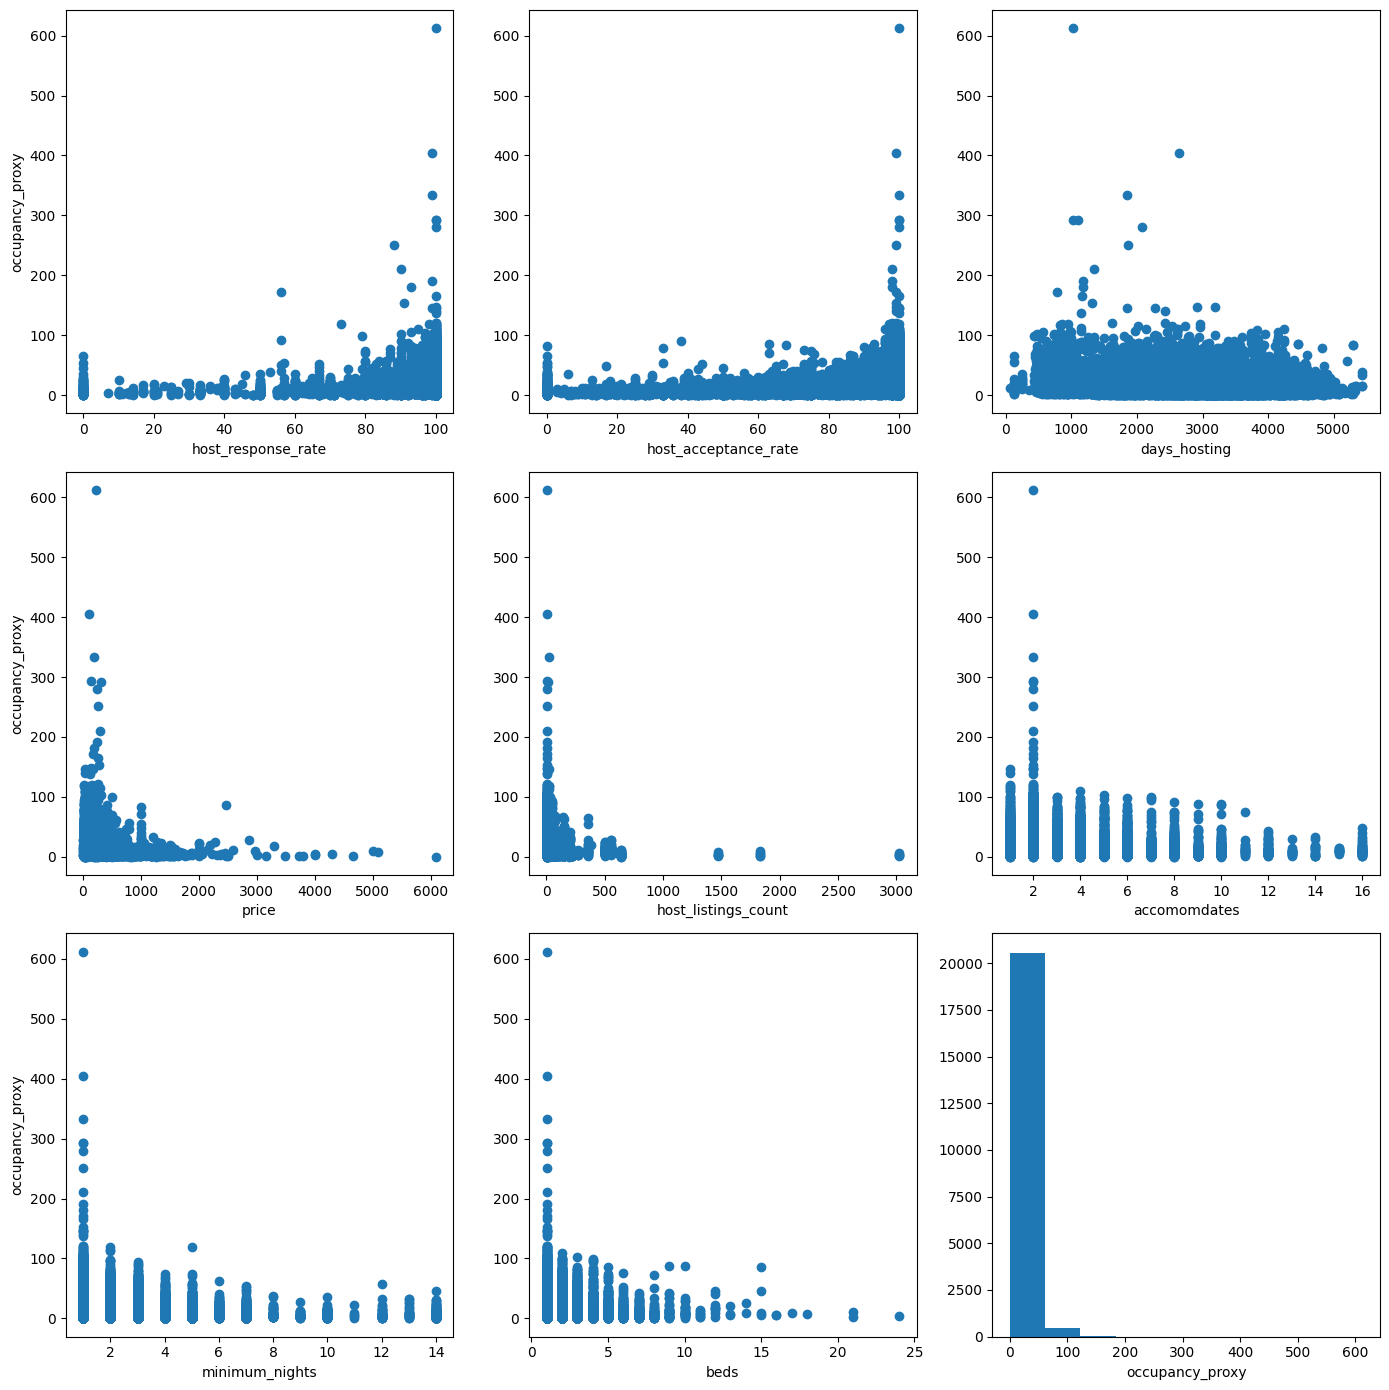

In [72]:
fig, axs = plt.subplots(3, 3, figsize=(14, 14))

for i, col in enumerate(air_train_num_cleaned.columns):
    if col != "occupancy_proxy":
        axs[i // 3, i % 3].scatter(air_train_num_cleaned[col], air_train_num_cleaned["occupancy_proxy"])
        axs[i // 3, i % 3].set_xlabel(col)
        if i % 3 == 0:
            axs[i // 3, i % 3].set_ylabel("occupancy_proxy")
    else:
        axs[i // 3, i % 3].hist(air_train_num_cleaned["occupancy_proxy"])
        axs[i // 3, i % 3].set_xlabel(col)

save_fig("scatter_plots")

Examining the mean "occupancy_proxy" for each category

In [73]:
columns_to_test = [
    "host_response_time",
    "host_has_profile_pic",
    "host_identity_verified",
    "room_type",
    "neighbourhood_cleansed"
]

Adding a boolean feature which is True when Wifi is listed as one of the amenitites. This choice was dictated by the fact that Wifi was the most common amenity among the listings

In [74]:
air_train_cleaned["has_wifi"] = air_train_cleaned["amenities"].apply(lambda x: True if "Wifi" in x else False)

In [75]:
means = {}

for col in columns_to_test:
    means[col] = air_train_cleaned.groupby(col)["occupancy_proxy"].mean().sort_values(ascending=False)

for col, mean_series in means.items():
    print(f"Means for {col}:")
    print(mean_series)
    print("-" * 50)
    if col == "neighbourhood_cleansed":
        mean_occupancy_per_borough = mean_series

Means for host_response_time:
host_response_time
within an hour        17.795012
within a few hours    11.204439
within a day           8.494982
a few days or more     8.044942
Name: occupancy_proxy, dtype: float64
--------------------------------------------------
Means for host_has_profile_pic:
host_has_profile_pic
f    17.182628
t    14.216119
Name: occupancy_proxy, dtype: float64
--------------------------------------------------
Means for host_identity_verified:
host_identity_verified
t    14.506640
f    10.375791
Name: occupancy_proxy, dtype: float64
--------------------------------------------------
Means for room_type:
room_type
Shared room        24.483344
Private room       18.337268
Entire home/apt    11.642959
Hotel room         10.706151
Name: occupancy_proxy, dtype: float64
--------------------------------------------------
Means for neighbourhood_cleansed:
neighbourhood_cleansed
City of London            21.494724
Camden                    17.638747
Hillingdon           

Since there are many boroughs, it was decided to create a choropleth maps once again, this time to visually represent the mean occupancy for each borough.

In [76]:
mean_occupancy_per_borough = mean_occupancy_per_borough.reset_index()
mean_occupancy_per_borough.columns = ["borough", "occupancy_proxy"]
mean_occupancy_per_borough
polygons_with_mean_occupancy = choropleth_gdf.merge(mean_occupancy_per_borough, left_on="NAME", right_on="borough", how="left")

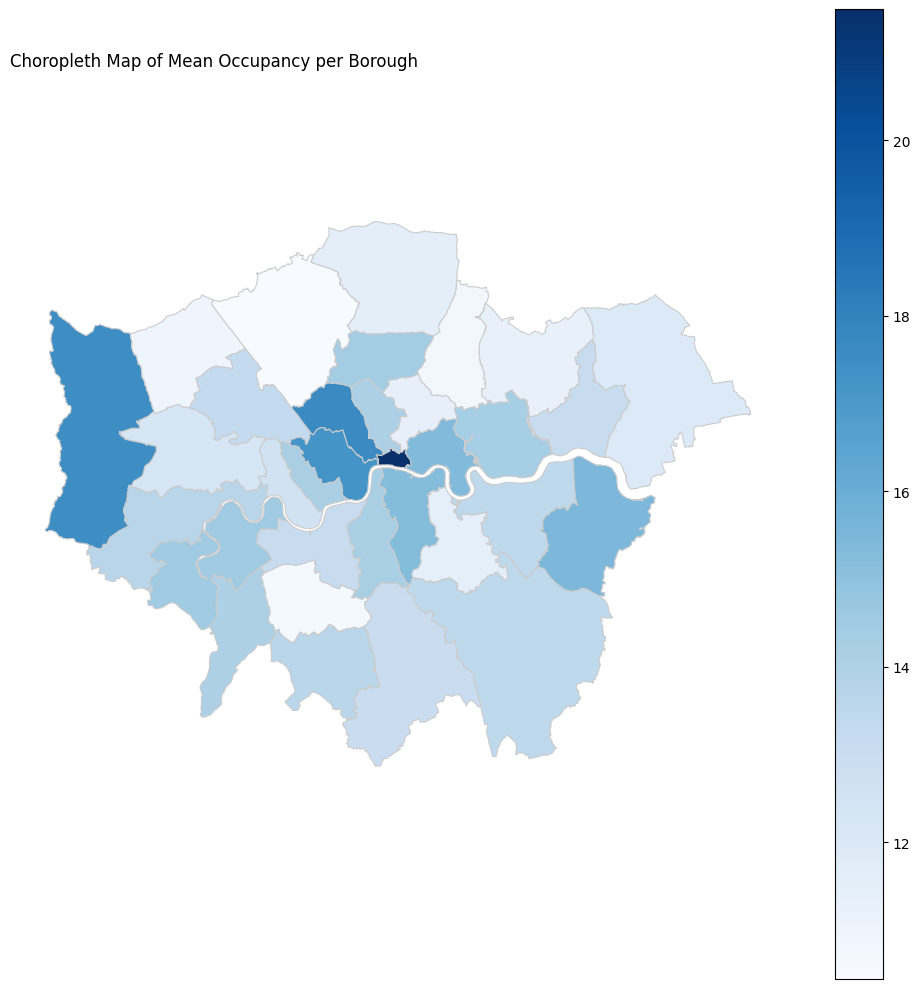

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

polygons_with_mean_occupancy.plot(column="occupancy_proxy", cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)
ax.axis("off")
ax.set_title('Choropleth Map of Mean Occupancy per Borough',
             fontdict={'fontsize': '12', 'fontweight' : '3'},
             loc='left',
             y=1.20)

save_fig("choropleth_map_mean_occupancy_per_borough")

Finally, Kruskal-Wallis test and Mann-Whitney U test where incorporated to examine if the differences in "occuapncy-proxy" between different categories were statisticaly significant.

In [78]:
results = {}

for col in columns_to_test:
    unique_values = air_train_cleaned[col].unique()

    # Lists to store the data for each unique value
    data_groups = [air_train_cleaned[air_train_cleaned[col] == val]["occupancy_proxy"].dropna() for val in unique_values]

# If there are only two unique values, use Mann-Whitney U test
    if len(unique_values) == 2 and all(len(group) > 0 for group in data_groups):
        stat, p = mannwhitneyu(*data_groups)
        results[col] = ("Mann-Whitney", stat, p)
# If there are more than two unique values, use Kruskal-Wallis test
    elif len(unique_values) > 2 and all(len(group) > 0 for group in data_groups if not group.empty):
        stat, p = kruskal(*[group for group in data_groups if not group.empty])
        results[col] = ("Kruskal-Wallis", stat, p)

In [79]:
pd.DataFrame([[key] + list(value) for key, value in results.items()],
              columns=["variable", "test", "test_statistic", "p-value"])

variable            test  test_statistic        p-value
0      host_response_time  Kruskal-Wallis    9.665234e+02  3.289255e-209
1    host_has_profile_pic    Mann-Whitney    1.072102e+06   2.399076e-03
2  host_identity_verified    Mann-Whitney    1.641790e+07   1.407616e-36
3               room_type  Kruskal-Wallis    7.702207e+02  1.243087e-166
4  neighbourhood_cleansed  Kruskal-Wallis    3.758864e+02   2.553378e-60

## 12.0 Patterns in Missing Data

In [80]:
air_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21024 entries, 36870 to 49554
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_since              21024 non-null  object 
 1   amenities               21024 non-null  object 
 2   host_response_time      16022 non-null  object 
 3   host_response_rate      16022 non-null  object 
 4   host_acceptance_rate    17297 non-null  object 
 5   host_listings_count     21024 non-null  float64
 6   host_has_profile_pic    21024 non-null  object 
 7   host_identity_verified  21024 non-null  object 
 8   neighbourhood_cleansed  21024 non-null  object 
 9   latitude                21024 non-null  float64
 10  longitude               21024 non-null  float64
 11  room_type               21024 non-null  object 
 12  accommodates            21024 non-null  int64  
 13  beds                    20729 non-null  float64
 14  price                   21024 non-

As can be seen in the above output,, there are three columns with a significant number of missing values. These columns are: "host_response_time", "host_response_rate" and "host_acceptance_rate". Since the number of missing values in two of them is identical, it was decided to explore if there are any patterns regarding which records have these values missing.

In [81]:
columns_to_check = ["host_response_time", "host_response_rate", "host_acceptance_rate"]

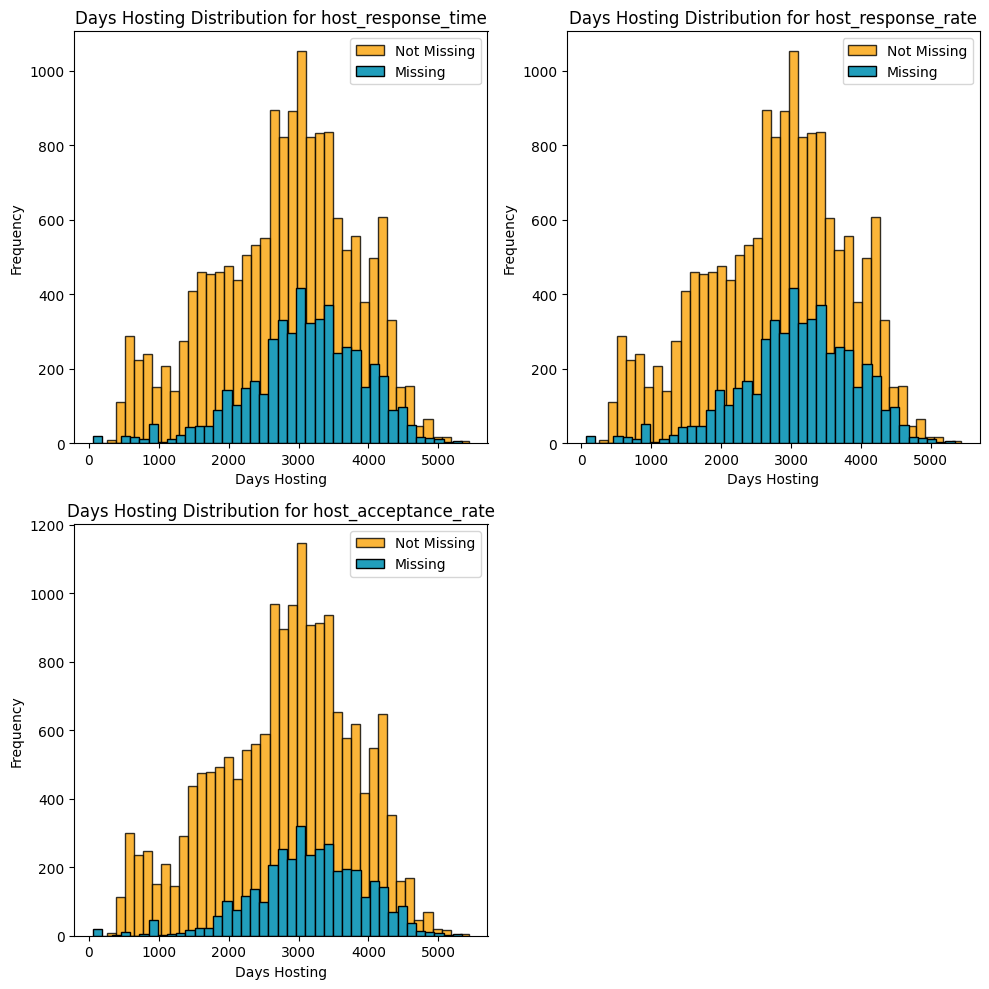

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    if i < len(columns_to_check):  # Only proceed if there's a corresponding column
        column = columns_to_check[i]
        is_missing = air_train_subset[column].isnull()

        axes[i // 2, i % 2].hist(days_hosting[~is_missing], bins=40, edgecolor='black', alpha=0.8, label='Not Missing', color="#faa307")
        axes[i // 2, i % 2].hist(days_hosting[is_missing], bins=40, edgecolor='black', label='Missing', color="#219ebc")

        axes[i // 2, i % 2].set_title(f'Days Hosting Distribution for {column}')
        axes[i // 2, i % 2].set_xlabel('Days Hosting')
        axes[i // 2, i % 2].set_ylabel('Frequency')
        axes[i // 2, i % 2].legend()
    else:
        # Turn off the axes for subplots that don't have data
        axes[i // 2, i % 2].axis('off')

plt.tight_layout()
save_fig("distribution_of_days_hosting_missing_nonmissing")
plt.show()

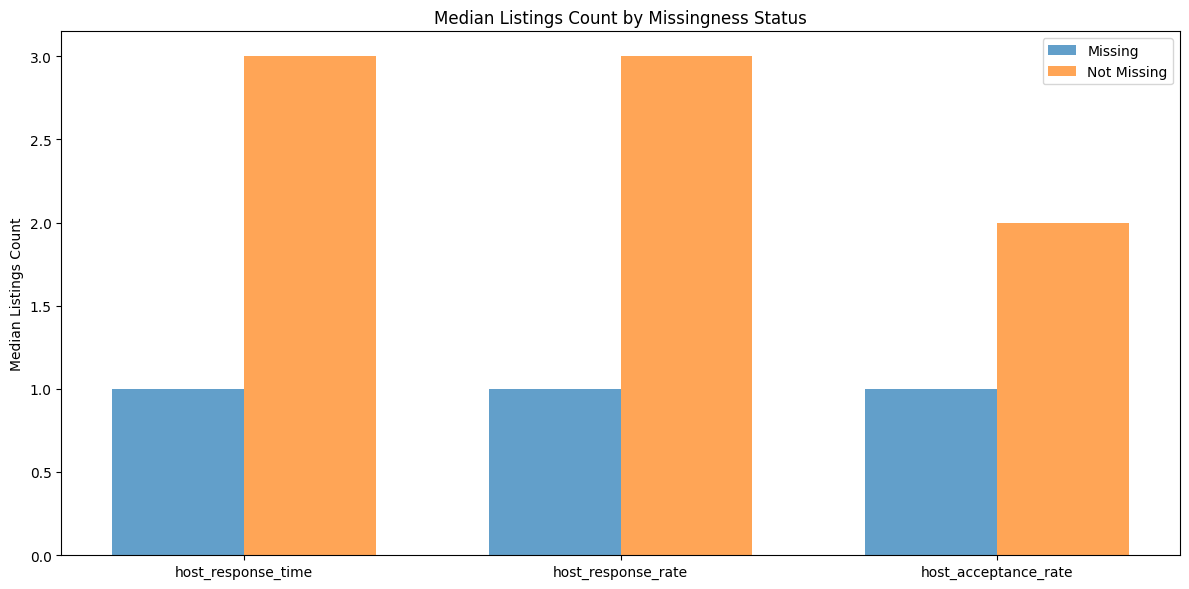

In [83]:
medians = []

for column in columns_to_check:
    is_missing = air_train_subset[column].isnull()

    # Calculate medians
    median_missing = air_train_cleaned["host_listings_count"][is_missing].median()
    median_not_missing = air_train_cleaned["host_listings_count"][~is_missing].median()
    medians.append((median_missing, median_not_missing))

# Plotting
labels = columns_to_check
missing_medians = [item[0] for item in medians]
not_missing_medians = [item[1] for item in medians]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
rects1 = plt.bar(x - width/2, missing_medians, width, label='Missing', alpha=0.7)
rects2 = plt.bar(x + width/2, not_missing_medians, width, label='Not Missing', alpha=0.7)

plt.ylabel('Median Listings Count')
plt.title('Median Listings Count by Missingness Status')
plt.xticks(x, labels)
plt.legend()

plt.tight_layout()
save_fig("median_listings_count_missing_nonmissing")
plt.show()

Since the "host_response_time" and "host_response_rate" exhibited the exact same number of missing values, it was decided to investigate if the "missingness" of one var has an influence of the "missingness" of the other.

In [84]:
air_train[(air_train["host_response_time"].isna()) & ~(air_train["host_response_rate"].isna())].shape

(0, 76)

It can be observed that there are no instances when one variable is missing for a particular listing and the other is not.

## 13.0 Pre-processing pipeline

Creating a separate series containing traning labels. The "occupancy_proxy" column is not dropped from the training set, since it is used during KMeans clustering.

In [85]:
air_train = air_train_cleaned
air_train_labels = air_train_cleaned["occupancy_proxy"].copy()

### 13.1 Formatting pipelines

This pipeline converts percentage strings in a column into float values. For example, it transforms "23%" into 23.0.

In [86]:
def rate_name(function_transformer, feature_names_in):
    return ["rate"]

string_to_float = FunctionTransformer(lambda df: (df.applymap(lambda x: float(x[:-1]) if type(x) == str else x)).values.reshape(-1, 1), feature_names_out=rate_name)

rate_pipeline = make_pipeline(string_to_float, SimpleImputer(strategy="median"), StandardScaler())

This pipeline calculates the number of days between the current date and the date the host registered on the website ("host_since").

In [87]:
def days_name(function_transformer, feature_names_in):
    return ["days"]

count_days = FunctionTransformer(lambda x: ((pd.Timestamp.now() - pd.Series(pd.to_datetime(x.iloc[:, 0]))).dt.days).values.reshape(-1, 1),
                                 feature_names_out=days_name)

count_days_pipeline = make_pipeline(count_days, SimpleImputer(strategy="median"), StandardScaler())

This pipeline converts price strings in a column into float values. For example, it transforms "$1,224.00" into 1224.

In [88]:
def price_name(function_transformer, feature_names_in):
    return ["price"]

def log_plus_small_number(x):
    return np.log(x + 0.01)

extract_price = FunctionTransformer(lambda df: df.applymap(lambda x: float(x[1:].replace(",", ""))),
                                    feature_names_out=price_name)

extract_price_pipeline = make_pipeline(extract_price,
                                       SimpleImputer(strategy="median"),
                                       FunctionTransformer(log_plus_small_number, feature_names_out="one-to-one"),
                                       StandardScaler())

The following pipeline processes a column where each cell contains a string-represented list of amenities, like '["am1", "am2", "am3"]'. It checks each list to see if "WiFi" is one of the amenities and then updates the column with True or False values accordingly.

In [89]:
def contains_name(function_transformer, feature_names_in):
    return ["found"]

find_element = FunctionTransformer(lambda df: (df.applymap(lambda x: 1 if "Wifi" in x else 0)).values.reshape(-1, 1),
                                    feature_names_out=contains_name)

find_element_pipeline = make_pipeline(find_element, SimpleImputer(strategy="most_frequent"))

### 13.2 Default pipelines

Default pipeline for numerical attricutes

In [90]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

Default pipeline for categorical attributes

In [91]:
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore", drop="first"))

This pipeline calculates RBF for each point and each identified cluster

In [92]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=275., random_state=42)
simil_pipeline = make_pipeline(SimpleImputer(strategy="median"), cluster_simil)

## 14.0 Data Preparation

In [93]:
preprocessing = ColumnTransformer([
    ("response", rate_pipeline, ["host_response_rate"]),
    ("acceptance", rate_pipeline, ["host_acceptance_rate"]),
    ("hosting", count_days_pipeline, ["host_since"]),
    ("daily", extract_price_pipeline, ["price"]),
    ("Wifi", find_element_pipeline, ["amenities"]),
    ("num", num_pipeline, ["host_listings_count", "accommodates", "minimum_nights"]),
    ("geo", simil_pipeline, ["longitude", "latitude", "occupancy_proxy"]),
    ("cat", cat_pipeline, ["host_response_time", "host_has_profile_pic", "host_identity_verified", "room_type"])
])

In [94]:
preprocessed_data = preprocessing.fit_transform(air_train)


In [95]:
preprocessed_data[1]

array([ 2.68734073e-01,  5.90163025e-01,  3.45036645e-01,  1.97866867e-01,
        1.00000000e+00, -1.90837218e-01, -5.86666091e-01,  4.06546884e-01,
        2.99235746e-05,  3.70087218e-01,  4.34514183e-06,  7.24275951e-10,
        4.43666884e-01,  1.07372285e-01,  1.24350622e-02,  5.03282898e-02,
        8.92486743e-01,  9.31699404e-18,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [96]:
preprocessed_data.shape

(21024, 26)

In [97]:
preprocessing.get_feature_names_out()

array(['response__rate', 'acceptance__rate', 'hosting__days',
       'daily__price', 'Wifi__found', 'num__host_listings_count',
       'num__accommodates', 'num__minimum_nights',
       'geo__Cluster 0 similarity', 'geo__Cluster 1 similarity',
       'geo__Cluster 2 similarity', 'geo__Cluster 3 similarity',
       'geo__Cluster 4 similarity', 'geo__Cluster 5 similarity',
       'geo__Cluster 6 similarity', 'geo__Cluster 7 similarity',
       'geo__Cluster 8 similarity', 'geo__Cluster 9 similarity',
       'cat__host_response_time_within a day',
       'cat__host_response_time_within a few hours',
       'cat__host_response_time_within an hour',
       'cat__host_has_profile_pic_t', 'cat__host_identity_verified_t',
       'cat__room_type_Hotel room', 'cat__room_type_Private room',
       'cat__room_type_Shared room'], dtype=object)

## 15.0 Model Selection

Since "occupancy_procy" is higly skewed, it was decided to fit the model to the log-transformed target variable.

### 15.1 Linear Regression

<Axes: >

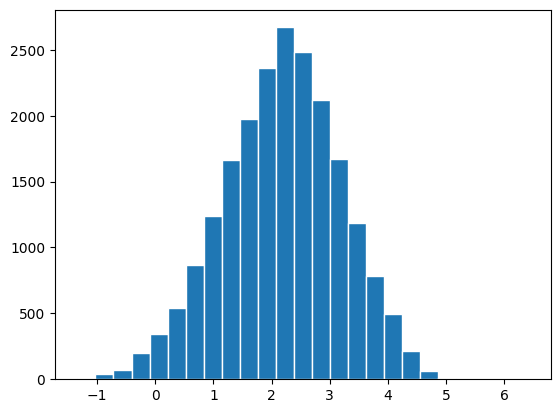

In [98]:
np.log(air_train["occupancy_proxy"]).hist(bins=25, edgecolor="white", grid=False)

In [99]:
lin_reg = make_pipeline(preprocessing, TransformedTargetRegressor(LinearRegression(), transformer=FunctionTransformer(np.log, inverse_func=np.exp)))
lin_reg.fit(air_train, air_train_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('response',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function rate_name at 0x785fa0dd04c0>,
                                                                                       func=<function <lambda> at 0x785fa0dd0d30>)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate']),
                                                 (...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'room_type'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)))])

Performing a 10-fold cross-validation using the linear regression model

In [100]:
linear_maes = -cross_val_score(lin_reg, air_train, air_train_labels, scoring="neg_mean_absolute_error", cv=10, verbose=3)

[CV] END ............................... score: (test=-8.709) total time=   2.8s
[CV] END ............................... score: (test=-8.685) total time=   2.6s
[CV] END ............................... score: (test=-8.620) total time=   3.4s
[CV] END ............................... score: (test=-8.673) total time=   3.4s
[CV] END ............................... score: (test=-7.957) total time=   2.4s
[CV] END ............................... score: (test=-8.292) total time=   2.5s
[CV] END ............................... score: (test=-8.107) total time=   2.9s
[CV] END ............................... score: (test=-8.661) total time=   3.8s
[CV] END ............................... score: (test=-9.296) total time=   3.0s
[CV] END ............................... score: (test=-8.436) total time=   2.4s


In [101]:
pd.Series(linear_maes).describe()

count    10.000000
mean      8.543842
std       0.374128
min       7.957152
25%       8.327783
50%       8.640942
75%       8.682303
max       9.296295
dtype: float64

It can be seen that the linear regression model with no regularization on average under underestimates or overestimates the "occupancy_proxy" by 8 reviews. Let's comapre it to the standard deviation of the target variable.

In [102]:
air_train_labels.describe()

count    21024.000000
mean        14.233333
std         16.656970
min          0.261836
25%          4.496920
50%          9.125000
75%         17.807292
max        612.125935
Name: occupancy_proxy, dtype: float64

### 15.2 LASSO Regression

In [103]:
lasso_reg = make_pipeline(preprocessing, TransformedTargetRegressor(Lasso(random_state=42), transformer=FunctionTransformer(np.log, inverse_func=np.exp)))
lasso_reg.fit(air_train, air_train_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('response',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function rate_name at 0x785fa0dd04c0>,
                                                                                       func=<function <lambda> at 0x785fa0dd0d30>)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate']),
                                                 (...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'room_type'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=Lasso(random_state=42),
                                            transformer=FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)))])

Performing a 10 fold cross validation

In [104]:
lasso_maes = -cross_val_score(lasso_reg, air_train, air_train_labels, scoring="neg_mean_absolute_error", cv=10, verbose=3)

[CV] END ............................... score: (test=-9.688) total time=   5.5s
[CV] END ............................... score: (test=-9.639) total time=   4.6s
[CV] END ............................... score: (test=-9.674) total time=   6.9s
[CV] END ............................... score: (test=-9.767) total time=   2.2s
[CV] END ............................... score: (test=-8.955) total time=   2.6s
[CV] END ............................... score: (test=-9.339) total time=   2.1s
[CV] END ............................... score: (test=-9.215) total time=   3.7s
[CV] END ............................... score: (test=-9.606) total time=   2.6s
[CV] END .............................. score: (test=-10.308) total time=   2.7s
[CV] END ............................... score: (test=-9.540) total time=   2.6s


In [105]:
pd.Series(lasso_maes).describe()

count    10.000000
mean      9.573295
std       0.360855
min       8.955303
25%       9.389388
50%       9.622662
75%       9.684904
max      10.307825
dtype: float64

The lasso regression is clearly doing worse than the regular regression. It was decided to examine how many coefficients were zeroed-out.

In [106]:
lasso_reg[1].regressor_.coef_

array([ 0.,  0., -0., -0., -0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
       -0.,  0.,  0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,  0.,  0.])

The default valuue of the penalty term in *Ridge* is 1. It was apparently to high, since all the coefficients were decreased to 0.

In [107]:
lasso_reg = make_pipeline(preprocessing, TransformedTargetRegressor(Lasso(random_state=42, alpha=0.01), transformer=FunctionTransformer(np.log, inverse_func=np.exp)))
lasso_reg.fit(air_train, air_train_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('response',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function rate_name at 0x785fa0dd04c0>,
                                                                                       func=<function <lambda> at 0x785fa0dd0d30>)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate']),
                                                 (...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'room_type'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=Lasso(alpha=0.01,
                                                            random_state=42),
                                            transformer=FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)))])

In [108]:
lasso_reg[1].regressor_.coef_

array([ 0.00252066,  0.18770466, -0.14812507, -0.10207485, -0.        ,
       -0.0519349 ,  0.01817375, -0.23524577,  0.        ,  0.20201329,
       -0.        ,  0.        ,  0.0549294 ,  0.        ,  0.13296749,
        0.11949675, -0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.25587556, -0.        ,  0.15298833,
        0.        ])

Setting the alpha parameter to 0.01 resulted in only some of the coefficients being zeroed-out.

In [109]:
lasso_maes = -cross_val_score(lasso_reg, air_train, air_train_labels, scoring="neg_mean_absolute_error", cv=10, verbose=3)

[CV] END ............................... score: (test=-8.817) total time=   3.8s
[CV] END ............................... score: (test=-8.806) total time=   2.7s
[CV] END ............................... score: (test=-8.749) total time=   2.5s
[CV] END ............................... score: (test=-8.793) total time=   2.1s
[CV] END ............................... score: (test=-8.044) total time=   3.8s
[CV] END ............................... score: (test=-8.403) total time=   2.5s
[CV] END ............................... score: (test=-8.242) total time=   2.3s
[CV] END ............................... score: (test=-8.735) total time=   2.6s
[CV] END ............................... score: (test=-9.424) total time=   3.7s
[CV] END ............................... score: (test=-8.589) total time=   2.4s


In [110]:
pd.Series(lasso_maes).describe()

count    10.000000
mean      8.660288
std       0.378170
min       8.043752
25%       8.449777
50%       8.742168
75%       8.802923
max       9.424215
dtype: float64

This time the mean absolute error across 10 folds of cross validation was lower, but still higher than for standard linear regression. This might mean that each of the variables is actually informative.

### 15.3 Random Forest

In [116]:
forest_reg = make_pipeline(preprocessing, TransformedTargetRegressor(RandomForestRegressor(random_state=42, verbose=1, max_features=20, n_estimators=100), transformer=FunctionTransformer(np.log, inverse_func=np.exp)))
forest_maes = -cross_val_score(forest_reg, air_train, air_train_labels, scoring="neg_mean_absolute_error", cv=10, verbose=3)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV] END ............................... score: (test=-7.567) total time=  27.7s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   13.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ............................... score: (test=-7.436) total time=  29.1s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ............................... score: (test=-7.439) total time=  28.5s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ............................... score: (test=-7.416) total time=  28.9s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV] END ............................... score: (test=-7.122) total time=  31.8s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ............................... score: (test=-7.323) total time=  28.5s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ............................... score: (test=-7.269) total time=  28.3s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   13.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ............................... score: (test=-7.720) total time=  30.0s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ............................... score: (test=-8.016) total time=  28.4s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.5s


[CV] END ............................... score: (test=-7.404) total time=  29.0s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [112]:
pd.Series(forest_maes).describe()

count    10.000000
mean      7.471265
std       0.250045
min       7.122293
25%       7.343187
50%       7.425878
75%       7.535081
max       8.016490
dtype: float64

Random forest with 100 estimators did better than linear regression models.

### 15.4 K-nearest neighbors

In [113]:
knn_reg = make_pipeline(
    preprocessing,
    TransformedTargetRegressor(
        KNeighborsRegressor(n_neighbors=25),
        transformer=FunctionTransformer(np.log, inverse_func=np.exp)
    )
)
knn_scores = -cross_val_score(knn_reg, air_train, air_train_labels, scoring="neg_mean_absolute_error", cv=10, verbose=3)

[CV] END ............................... score: (test=-8.340) total time=   2.6s
[CV] END ............................... score: (test=-8.357) total time=   2.8s
[CV] END ............................... score: (test=-8.304) total time=   4.1s
[CV] END ............................... score: (test=-8.329) total time=   3.1s
[CV] END ............................... score: (test=-7.776) total time=   2.6s
[CV] END ............................... score: (test=-8.098) total time=   2.9s
[CV] END ............................... score: (test=-7.924) total time=   3.8s
[CV] END ............................... score: (test=-8.372) total time=   2.6s
[CV] END ............................... score: (test=-8.865) total time=   2.9s
[CV] END ............................... score: (test=-8.289) total time=   2.4s


In [114]:
pd.Series(knn_scores).describe()

count    10.000000
mean      8.265390
std       0.293527
min       7.775512
25%       8.145966
50%       8.316423
75%       8.352436
max       8.865310
dtype: float64

K Nearest Neighbours model performed marginally better than Linear Regression model, and significantly worse than the Random Forest.

### 15.5 Hyperparameter Tuning

In [120]:
full_pipeline = Pipeline([
  ("preprocessing", preprocessing),
  ("random_forest", TransformedTargetRegressor(RandomForestRegressor(random_state=42, max_features=20, n_estimators=100), transformer=FunctionTransformer(np.log, inverse_func=np.exp))),
])
param_grid = [
  {'preprocessing__geo__clustersimilarity__n_clusters': [5, 8, 10],
   'random_forest__regressor__max_features': [4, 6, 8]},
  {'preprocessing__geo__clustersimilarity__n_clusters': [10, 15],
   'random_forest__regressor__max_features': [8, 10, 15, 20]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
scoring='neg_mean_absolute_error')
grid_search.fit(air_train, air_train_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('response',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<function rate_name at 0x785fa0dd04c0>,
                                                                                                              func=<function <lambda> at 0x785fa0dd0d30>)),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         [...
                                                                   transformer=FunctionTransformer(func=<ufunc 'log'>,
                                                                                                   inverse_func=<ufunc 'exp'>)))]),
             param_grid=[{'preprocessing__geo__clustersimilarity__n_clusters': [5,
                                                                                8,
                                                                                10],
                          'random_forest__regressor__max_features': [4, 6, 8]},
                         {'preprocessing__geo__clustersimilarity__n_clusters': [10,
                                                                                15],
                          'random_forest__regressor__max_features': [8, 10, 15,
                                                                     20]}],
             scoring='neg_mean_absolute_error')

In [121]:
grid_search.best_params_

{'preprocessing__geo__clustersimilarity__n_clusters': 5,
 'random_forest__regressor__max_features': 6}

In [122]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [123]:
cv_res

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1        7.233004      0.606225         0.286488        0.005684   
11      16.733267      0.534605         0.276945        0.013466   
2        8.427284      0.361249         0.303881        0.037523   
10      12.006965      0.185254         0.283622        0.006852   
12      20.539223      0.677544         0.278068        0.009898   
5        9.683605      0.509944         0.299545        0.035586   
0        6.065505      0.610670         0.277488        0.006131   
16      23.289347      0.260449         0.296422        0.027816   
4        8.303477      0.705749         0.274892        0.008532   
15      18.159150      0.333563         0.315464        0.043213   
9       10.409046      0.184211         0.273152        0.007910   
8       10.191189      0.272317         0.298085        0.032500   
14      13.662098      0.360687         0.302951        0.039597   
7        8.482385      0.208518         0.293816        0.032001   
3        7.197094      1.553308         0.275109        0.002251   
13      11.491572      0.575042         0.357187        0.027755   
6        6.995117      0.632451         0.271031        0.004910   

   param_preprocessing__geo__clustersimilarity__n_clusters  \
1                                                   5        
11                                                 10        
2                                                   5        
10                                                 10        
12                                                 10        
5                                                   8        
0                                                   5        
16                                                 15        
4                                                   8        
15                                                 15        
9                                                  10        
8                                                  10        
14                                                 15        
7                                                  10        
3                                                   8        
13                                                 15        
6                                                  10        

   param_random_forest__regressor__max_features  \
1                                             6   
11                                           15   
2                                             8   
10                                           10   
12                                           20   
5                                             8   
0                                             4   
16                                           20   
4                                             6   
15                                           15   
9                                             8   
8                                             8   
14                                           10   
7                                             6   
3                                             4   
13                                            8   
6                                             4   

                                               params  split0_test_score  \
1   {'preprocessing__geo__clustersimilarity__n_clu...          -7.565228   
11  {'preprocessing__geo__clustersimilarity__n_clu...          -7.562759   
2   {'preprocessing__geo__clustersimilarity__n_clu...          -7.573841   
10  {'preprocessing__geo__clustersimilarity__n_clu...          -7.541208   
12  {'preprocessing__geo__clustersimilarity__n_clu...          -7.558118   
5   {'preprocessing__geo__clustersimilarity__n_clu...          -7.556544   
0   {'preprocessing__geo__clustersimilarity__n_clu...          -7.581208   
16  {'preprocessing__geo__clustersimilarity__n_clu...          -7.566683   
4   {'preprocessing__geo__clustersimilarity__n_clu...      

## 16.0 Model Evaluation

In [124]:
best_model = grid_search.best_estimator_

In [125]:
final_predictions = best_model.predict(air_test)

In [126]:
mean_absolute_error(final_predictions, air_test["occupancy_proxy"])

7.474111354460609

The MAE obtained on the test set was only slightly worse than mean MAE obtained during cross validation. It was decidaded to check the performance of the model on different Quartiles of the dataset.

In [127]:
air_test["occupancy_proxy"].describe()

count    5259.000000
mean       14.276927
std        16.351701
min         0.289568
25%         4.488280
50%         9.087137
75%        17.734794
max       241.069767
Name: occupancy_proxy, dtype: float64

In [128]:
Q1 = air_test[air_test["occupancy_proxy"] <= 4.291495]
Q2 = air_test[(air_test["occupancy_proxy"] > 4.291495) & (air_test["occupancy_proxy"] <= 8.718731)]
Q3 = air_test[(air_test["occupancy_proxy"] > 8.71873) & (air_test["occupancy_proxy"] <= 17.090059)]
Q4 = air_test[(air_test["occupancy_proxy"] > 17.090059)]

In [129]:
Q1_predictions = best_model.predict(Q1)
Q2_predictions = best_model.predict(Q2)
Q3_predictions = best_model.predict(Q3)
Q4_predictions = best_model.predict(Q4)

In [130]:
mean_absolute_error(Q1_predictions, Q1["occupancy_proxy"])

3.9998017798749785

In [131]:
mean_absolute_error(Q2_predictions, Q2["occupancy_proxy"])

3.153975394097619

In [132]:
mean_absolute_error(Q3_predictions, Q3["occupancy_proxy"])

4.122472172365547

In [133]:
mean_absolute_error(Q4_predictions, Q4["occupancy_proxy"])

17.829983016000217

As can be seen, the MAE is the lowest for listings with "occupancy_proxy" between 4.29 and 8.71. Finally, it was decided to compare the MAE achieved by the model to MAE achieved by predicting the mean and the median of the training labels for each point in the test set.

In [134]:
mean_absolute_error(air_test["occupancy_proxy"], np.repeat(air_train["occupancy_proxy"].mean(), len(air_test)))

10.660865870270117

In [135]:
mean_absolute_error(air_test["occupancy_proxy"], np.repeat(air_train["occupancy_proxy"].median(), len(air_test)))

9.694315177455438

The MAE achieved by the model is only slightly lower than MAE achieved by predicting the training median for each data point. In conclusion, machine learning algorithms applied to the data provided by Inside Airbnb have a very limited potential in predicting the popularity of a listing. This is of course assuming that some other variables, that were not included in the model, wouldn't drastically improve the performance.

## 17.0 Feature Importance Analysis

In [136]:
feature_importances = best_model["random_forest"].regressor_.feature_importances_

In [137]:
sorted(zip(feature_importances,
           best_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.1263243212859992, 'hosting__days'),
 (0.10567265233559106, 'acceptance__rate'),
 (0.10372402874912788, 'num__minimum_nights'),
 (0.10319275730273395, 'daily__price'),
 (0.10159515811643227, 'geo__Cluster 1 similarity'),
 (0.09783294319091064, 'geo__Cluster 4 similarity'),
 (0.08918572051867525, 'geo__Cluster 0 similarity'),
 (0.06176524801138385, 'num__host_listings_count'),
 (0.056425002448392665, 'geo__Cluster 3 similarity'),
 (0.03839468361618061, 'num__accommodates'),
 (0.025518454520796933, 'geo__Cluster 2 similarity'),
 (0.022617462389357815, 'cat__room_type_Private room'),
 (0.02095114409698776, 'response__rate'),
 (0.012030124078780733, 'cat__host_identity_verified_t'),
 (0.011131039517758812, 'cat__host_response_time_within an hour'),
 (0.008153457596418211, 'Wifi__found'),
 (0.00580023473423362, 'cat__host_response_time_within a day'),
 (0.005744271920147555, 'cat__host_response_time_within a few hours'),
 (0.00214856527338035, 'cat__room_type_Hotel room'),
 (0.0009363196

The number of days host was registered on the website turned out to be most important variable according to the Mean Decrease in Impurity. This could be because hosts that registered many years ago are likely to have taken some breaks from hosting, which would result in lowering the "occupancy_proxy". If that was indeed te case, the variable would not be of value for new hosts wanting to estimate the popularity of their listing.

Text(0, 0.5, 'Occupancy Proxy')

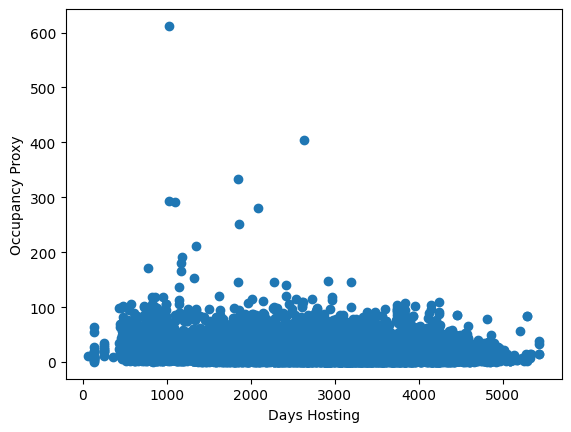

In [138]:
plt.scatter(air_train_num["days_hosting"], air_train_subset["occupancy_proxy"])
plt.xlabel("Days Hosting")
plt.ylabel("Occupancy Proxy")

The scatter plot indicates that high values of "occupancy_proxy" are more comong among the newly registered  hosts. WHn it comes to the "acceptance_rate", its correlation with the number of reviews, which was used to dervide the "occupancy_proxy" is quite obvious, and also isn't of much value for potential hosts.

Text(0, 0.5, 'Occupancy Proxy')

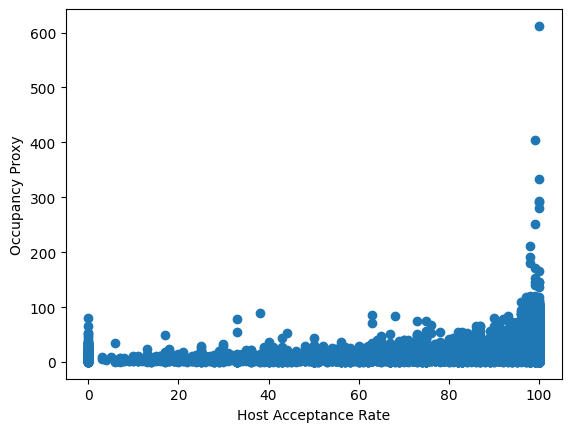

In [139]:
plt.scatter(air_train_num["host_acceptance_rate"], air_train_subset["occupancy_proxy"])
plt.xlabel("Host Acceptance Rate")
plt.ylabel("Occupancy Proxy")

However, the importance of the following three variables: "minimum_nights", "price" and "geo__Cluster 0 similarity" is potentially an important findings.

Text(0, 0.5, 'Occupancy proxy')

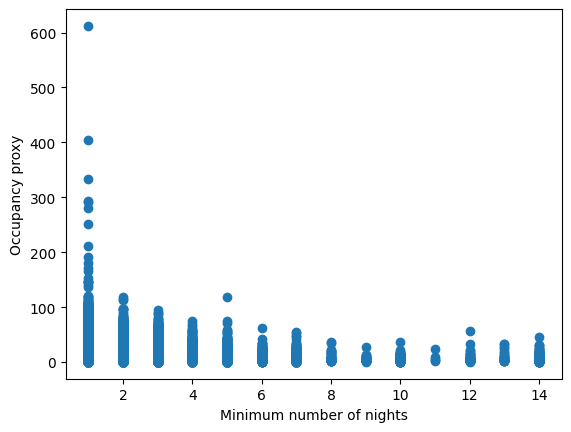

In [140]:
plt.scatter(air_train_num["minimum_nights"], air_train_subset["occupancy_proxy"])
plt.xlabel("Minimum number of nights")
plt.ylabel("Occupancy proxy")

The above scatter plot suggests that listings that can be booked for 1-3 night are more popular than listings where the minimum number of nights is higher.

Text(0, 0.5, 'Occupancy proxy')

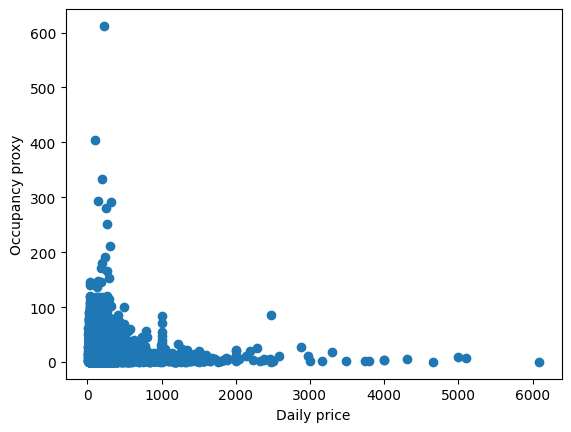

In [141]:
plt.scatter(air_train_num_cleaned["price"], air_train_cleaned["occupancy_proxy"])
plt.xlabel("Daily price")
plt.ylabel("Occupancy proxy")

Intuitively, we observe that listings with higher prices tend to be less popular. Future research could delve deeper into the relationship between price and "occupancy_proxy" across different price brackets.

Finally, it turned out that similiarity to cluster 1 is the most important out of the cluster similarities. All 5 clusters are plotted on a map of London down below.

In [142]:
centroids = best_model["preprocessing"].named_transformers_["geo"].named_steps["clustersimilarity"].kmeans_.cluster_centers_

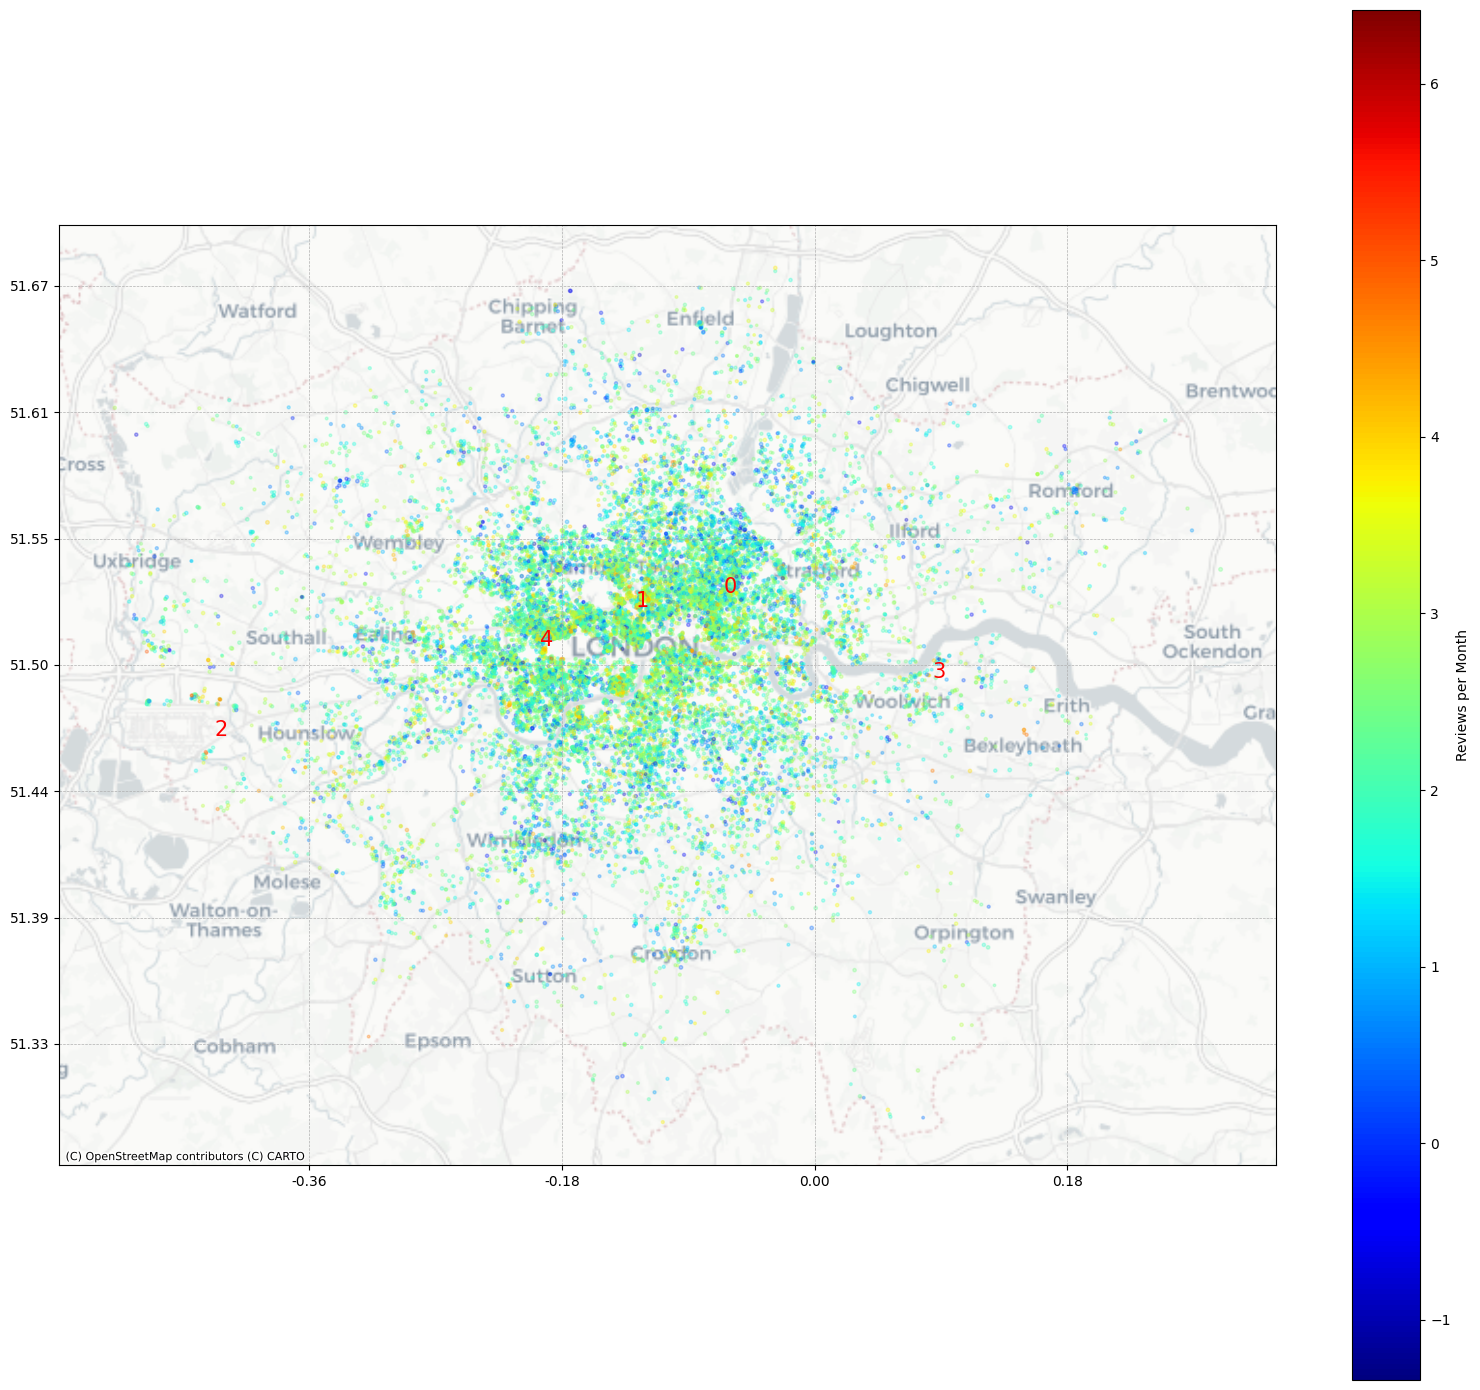

In [143]:
fig, ax = plt.subplots(figsize=(16, 14))

# Create a colormap
cmap = plt.get_cmap('jet')
norm = Normalize(vmin=transformed_data.min(),
                 vmax=transformed_data.max())

# Convert to Web Mercator
gdf_clusters = gdf_clusters.to_crs(epsg=3857)

# Plot the GeoDataFrame
gdf_clusters.plot(ax=ax,
             color=cmap(norm(transformed_data)),
             markersize=np.log(price),
             alpha=0.3)

centroids_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(centroids[:, 0], centroids[:, 1])
)

# Transform to Web Mercator
centroids_gdf = centroids_gdf.set_crs(epsg=4326).to_crs(epsg=3857)

# Loop through the centroids and annotate each one with its number
for idx, point in enumerate(centroids_gdf.geometry):
    ax.text(point.x, point.y, str(idx), color='red', fontsize=15, ha='center', va='center')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create a colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=ax, orientation='vertical', label='Reviews per Month')

# Add grid with rounded tick labels
xticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 5)
yticks = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5)

# Create a transformer to convert from Web Mercator to WGS 84
transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")

def x_formatter(x, pos):
    _, lon = transformer.transform(x, 0)  # Use x as longitude and 0 for latitude
    return f"{lon:.2f}"

def y_formatter(y, pos):
    lat, _ = transformer.transform(0, y)  # Use 0 for longitude and y as latitude
    return f"{lat:.2f}"

# Convert xticks and yticks from Web Mercator to WGS 84
xticks_latlon = [transformer.transform(x, 0)[0] for x in xticks]
yticks_latlon = [transformer.transform(0, y)[1] for y in yticks]


ax.xaxis.set_major_formatter(FuncFormatter(x_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(y_formatter))

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

save_fig("final_clusters")

plt.show()